# Figures and Tables for the paper

In [1]:
from pathlib import Path
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

In [3]:
WHICH_YOLO_VERSION = "V9"  # V8, V10, V11, V12

In [4]:
# # Create folders
# folders_to_consider = [
#     Path(f"results/{WHICH_YOLO_VERSION}/fmap_method"),
#     Path(f"results/{WHICH_YOLO_VERSION}/fmap_method_EUL"),
#     Path(f"results/{WHICH_YOLO_VERSION}/fmap_method_SDR"),
#     Path(f"results/{WHICH_YOLO_VERSION}/logits_methods"),
#     Path(f"results/{WHICH_YOLO_VERSION}/fusion_methods"),
# ]

# for folder in folders_to_consider:
#     if not folder.exists():
#         folder.mkdir(parents=True)

### Constants

In [5]:
# DECIDE THE SUBSET TO USE
WHICH_SUBSET = 'SUM'  # Options are 'COOD', 'CMIX' and 'SUM'. SUM is the combination of COOD and CMIX

# Constants for dataframes
INITIAL_COLUMNS = ['Method', 'which_split', 'conf_thr_train', 'conf_thr_test', 'tpr_thr',
       'cluster_method', 'mean_n_clus', 'std_n_clus', 'fusion_strat',
       'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP',
       'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'A-OSE',
       'WI-08', 'mAP_(VOC_test)', 'Model', 'args', 'custom_hyp']

FINAL_COLUMNS = ['Method', 'cluster_method', 'fusion_strat',
                 'mAP_(VOC_test)',
                 'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                 'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08', 'U-F1_(SUM)']

FINAL_COLUMNS_WITH_CONF_THR = ['Method', 'cluster_method',
                                'conf_thr_test',
                                'mAP_(VOC_test)',
                                'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                                'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08']

FINAL_COLUMNS_FUSION = FINAL_COLUMNS_WITH_CONF_THR + ['fusion_strat']

# For latex
ORDER_FOR_LATEX_ROWS = [
    '$L_1$', '$L_2$', 'Cosine', '$L^{SDR}_1$', '$L^{SDR}_2$', 'Cosine$^{SDR}$', '$L^{EUL}_1$', '$L^{EUL}_2$', 'Cosine$^{EUL}$'
]
COLUMNS_TO_ORDER_FOR_LATEX = ['Method', 'Distance Metric', 'Cluster Method', 'Confidence Threshold',
                              'mAP_(VOC_test)',
                              'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                              'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08']


COLUMNS_FOR_LATEX = ['Method', 'Distance Metric', 'Cluster Method', 'Confidence Threshold',
                     'mAP',
                     'U-AP', 'U-F1', 'U-PRE', 'U-REC',
                     'mAP', 'U-AP', 'U-F1', 'U-PRE', 'U-REC', 'A-OSE', 'WI']

LATEX_PARAMS = {
    'index': False,
    'float_format': '%.3f',
    'bold_rows': True,
    #'header': COLUMNS_FOR_LATEX,
}

LOGITS_METHODS = {
    'MSP': 'MSP',
    'Energy': 'Energy',
    'ODIN': 'ODIN',
}

DISTANCE_METHODS = {
    'L1_cl_stride': '$L_1$',
    'L2_cl_stride': '$L_2$',
    'Cosine_cl_stride': '$Cosine$',
    'L1Ivis': '$L^{SDR}_1$',
    'L2Ivis': '$L^{SDR}_2$',
    'CosineIvis': '$Cosine^{SDR}$',
}

FUSION_METHODS = {
    'fusion-MSP-Energy': 'MSP-Energy',
    'fusion-MSP-ODIN': 'MSP-ODIN',
    'fusion-MSP-Energy-ODIN': 'MSP-Energy-ODIN',
    'fusion-MSP-L1_cl_stride': 'MSP-$L_1$',
    'fusion-MSP-L2_cl_stride': 'MSP-$L_2$',
    'fusion-MSP-Cosine_cl_stride': 'MSP-$Cosine$',
    'fusion-MSP-L1Ivis': 'MSP-$L^{SDR}_1$',
    'fusion-MSP-L2Ivis': 'MSP-$L^{SDR}_2$',
    'fusion-MSP-CosineIvis': 'MSP-$Cosine^{SDR}$',
    'fusion-L1_cl_stride-CosineIvis': '$L_1$-$Cosine^{SDR}$',
    'fusion-Cosine_cl_stride-CosineIvis': '$Cosine$-$Cosine^{SDR}$',
}

# Join the dictionaries
NEW_NAMES_FOR_METHODS = {**DISTANCE_METHODS, **FUSION_METHODS, **LOGITS_METHODS}

WHICH_FUSION_TYPE = {
    'MSP-Energy': 'logit-logit',
    'MSP-ODIN': 'logit-logit',
    'MSP-Energy-ODIN': 'logit-logit',
    'MSP-$L_1$': 'logit-FMap',
    'MSP-$L_2$': 'logit-FMap',
    'MSP-$Cosine$': 'logit-FMap',
    'MSP-$L^{SDR}_1$': 'logit-FMap',
    'MSP-$L^{SDR}_2$': 'logit-FMap',
    'MSP-$Cosine^{SDR}$': 'logit-FMap',
    '$L_1$-$Cosine$^{SDR}$': "FMap-FMap'",
    '$L_1$-$Cosine^{SDR}$': "FMap-FMap'",  # Para arreglar un problema con el nombre que me ha surgido
    '$Cosine$-$Cosine^{SDR}$': "FMap-FMap'",
}


CLUSTER_METHODS_TO_KEEP = ['one', 'all', 'KMeans', 'KMeans_10', 'HDBSCAN', '-', 'KMeans_10-HDBSCAN', 'one-HDBSCAN']
NEW_NAMES_FOR_CLUSTER_METHODS = {
    'one': '$One$',
    'all': '$All$',
    'DBSCAN': '$DBSCAN$',
    'KMeans': '$KMeans$',
    'KMeans_10': '$KMeans^{10}$',
    'HDBSCAN': '$HDBSCAN$',
    'AgglomerativeClustering': '$Agglomerative$',
    'KMeans_10-HDBSCAN': 'KMeans_10-$HDBSCAN$',
}

# Paths
#NORMAL_TEX_PATH = Path(f"results/{WHICH_YOLO_VERSION}/RQ1/rq1.tex")
FIGURES_FOLDER = Path("figures")
RQ1_FIGURES_FOLDER = FIGURES_FOLDER / "RQ1"
RQ1_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)
RQ2_FIGURES_FOLDER = FIGURES_FOLDER / "RQ2"
RQ2_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)
RQ3_FIGURES_FOLDER = FIGURES_FOLDER / "RQ3"
RQ3_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)
RQ4_FIGURES_FOLDER = FIGURES_FOLDER / "RQ4"
RQ4_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)

# Plot style
default_markers = ['o', 'X', 's', 'D', '^', 'v', '<', '>', 'P', '*']
MARKERS = {
    '$L_1$': 's',
    '$L_2$': 'D',
    '$Cosine$': 'o',
    '$L^{SDR}_1$': 'h',
    '$L^{SDR}_2$': 'd',
    '$Cosine^{SDR}$': '8',
    'MSP': 'P',#'v',
    'Energy': 'P',#'P',
    'ODIN': 'P',#'X',
    '$ND_{prev}$': '*',
}

### Functions

In [6]:
def search_for_paths_with_extension(path: Path, extension=".csv") -> List[Path]:
    # Recursively search for all files with the extension
    paths = []
    for p in path:
        if p.is_dir():
            paths += search_for_paths_with_extension(list(p.iterdir()), extension)
        elif p.is_file() and p.suffix == extension:
            paths.append(p)
    return paths

def convert_list_of_paths_into_df(paths: list[Path], extension=".csv"):
    # Read the documents and concat into one big dataframe
    if len(paths) == 0:
        raise ValueError("No paths found")
    
    # Extrac the .csv files from the paths
    paths = search_for_paths_with_extension(paths, extension)
    print(paths)

    for doc in paths:
        df = pd.read_csv(doc)
        # Check if all initial columns are present. If not, add them 
        if not all(col in df.columns for col in INITIAL_COLUMNS):
            for col in INITIAL_COLUMNS:
                if col not in df.columns:
                    print(f"Column {col} not found in {doc}")
                    df[col] = np.nan
        
        # Check if the dataframe is the first one
        if doc == paths[0]:
            dataframe = df
        else:  # If not, concat the dataframes
            dataframe = pd.concat([dataframe, df])    

    return dataframe

def format_df(df, columns_to_keep=None):
    # CONTENT CHANGES
    if columns_to_keep:
        dataframe = df[columns_to_keep]
    else:
        dataframe = df[FINAL_COLUMNS]
    # Display only 3 decimals
    dataframe = dataframe.round(3)
    # Convert A-OSE to int
    dataframe['A-OSE'] = dataframe['A-OSE'].astype(int)
    # Replace NaNs with -
    dataframe = dataframe.fillna('-')
    # Keep only certain rows
    dataframe = dataframe[dataframe['cluster_method'].isin(CLUSTER_METHODS_TO_KEEP)]
    # Create a new column with the sum of F1 metric in CMIX and COOD
    dataframe['U-F1_(SUM)'] = dataframe['U-F1_(CMIX)'] + dataframe['U-F1_(COOD)']


    # NAME CHANGES
    # Change the Method names
    dataframe['Method'] = dataframe['Method'].replace(NEW_NAMES_FOR_METHODS)
    # Change the cluster method names
    dataframe['cluster_method'] = dataframe['cluster_method'].replace(NEW_NAMES_FOR_CLUSTER_METHODS)
    return dataframe


def obtain_best_values_of_columns(df, columns_to_search_max, columns_to_search_min):
    # Extract values to dicts of max and min values per
    max_values = {}
    min_values = {}
    for col in columns_to_search_max:
        df[col] = df.groupby(['Method'])[col].transform('max')
        max_values[col] = df[col].max().round(3)
    for col in columns_to_search_min:
        df[col] = df.groupby(['Method'])[col].transform('min')
        min_values[col] = df[col].min().round(3)
    return max_values, min_values  


def obtain_non_dominated_points_positions_map_f1(dataframe: pd.DataFrame, which_subset: str):
    non_dominated_points = []
    for i in range(len(dataframe)):
        is_dominated = False
        for j in range(len(dataframe)):
            if i == j:
                continue
            if dataframe['mAP'][i] < dataframe['mAP'][j] and dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j]:
                is_dominated = True
                break
            else:
                # If the points are the same, then they are not dominated
                if dataframe['mAP'][i] == dataframe['mAP'][j] and dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j]:
                    pass
                else:
                    # If the points are the same in one of the metrics, then check the other metric
                    if dataframe['mAP'][i] == dataframe['mAP'][j]:
                        if dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j]:
                            is_dominated = True
                            break
                    if dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j]:
                        if dataframe['mAP'][i] < dataframe['mAP'][j]:
                            is_dominated = True
                            break
        if not is_dominated:
            non_dominated_points.append(i)
    return non_dominated_points


def obtain_non_dominated_points_positions_map_f1_aose(dataframe: pd.DataFrame, which_subset: str):
    non_dominated_points = []
    for i in range(len(dataframe)):
        is_dominated = False
        for j in range(len(dataframe)):
            if i == j:
                continue
            if (
                dataframe['mAP'][i] < dataframe['mAP'][j] and
                dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j] and
                dataframe['A-OSE'][i] > dataframe['A-OSE'][j]
            ):
                is_dominated = True
                break
            else:
                # If the points are the same, then they are not dominated
                if (
                    dataframe['mAP'][i] == dataframe['mAP'][j] and
                    dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j] and
                    dataframe['A-OSE'][i] == dataframe['A-OSE'][j]
                ):
                    pass
                else:
                    continue
                    # Check if the current point is dominated in one of the metrics
                    if dataframe['mAP'][i] == dataframe['mAP'][j]:
                        if (
                            dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j] and
                            dataframe['A-OSE'][i] > dataframe['A-OSE'][j]
                        ):
                            is_dominated = True
                            break
                    if dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j]:
                        if (
                            dataframe['mAP'][i] < dataframe['mAP'][j] and
                            dataframe['A-OSE'][i] > dataframe['A-OSE'][j]
                        ):
                            is_dominated = True
                            break
                    if dataframe['A-OSE'][i] == dataframe['A-OSE'][j]:
                        if (
                            dataframe['mAP'][i] < dataframe['mAP'][j] and
                            dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j]
                        ):
                            is_dominated = True
                            break
        if not is_dominated:
            non_dominated_points.append(i)
    return non_dominated_points


from adjustText import adjust_text

def add_shaded_areas(df, ax, colors, subset_col, x_col, y_col, bw_adjust=0.3, alpha=0.2, levels=2):
    """
    Adds shaded areas to a plot based on kernel density estimation.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        ax (Axes): The axes on which to plot.
        colors (list): A list of colors for different cluster methods.
        subset_col (str): The column name to subset the DataFrame.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        bw_adjust (float): The bandwidth adjustment value for KDE.
        alpha (float): The alpha value for the shaded areas.
        levels (int): The number of contour levels to plot.
    """
    for method, color in zip(df[subset_col].unique(), colors):
        subset = df[df[subset_col] == method]
        sns.kdeplot(
            x=subset[x_col], 
            y=subset[y_col], 
            ax=ax, 
            fill=True, 
            color=color, 
            alpha=alpha, 
            legend=False, 
            bw_adjust=bw_adjust,
            linewidth=0, 
            levels=levels
        )


def highlight_non_dominated_points(ax, df, indices, x_col, y_col, marker_size, edge_color, linewidth, face_color='none', marker='o', zorder=0):
    """
    Highlights the non-dominated points on a plot.

    Parameters:
        ax (Axes): The axes on which to plot.
        df (DataFrame): The DataFrame containing the data.
        indices (list): The indices of the non-dominated points.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        marker_size (int): The size of the markers.
        edge_color (str): The color of the edges of the markers.
        linewidth (float): The linewidth of the marker edges.
        face_color (str): The face color of the markers.
        marker (str): The marker style.
        zorder (int): The zorder of the markers.
    """
    for i in indices:
        ax.scatter(
            df[x_col][i], 
            df[y_col][i], 
            s=marker_size, 
            facecolors=face_color, 
            marker=marker, 
            zorder=zorder, 
            edgecolors=edge_color, 
            linewidths=linewidth
        )


def add_line_connecting_non_dominated_points(ax, df, indices, x_col, y_col, line_color, line_style='--', line_width=1):
    """
    Adds a line connecting the non-dominated points in descending order of y_col.

    Parameters:
        ax (Axes): The axes on which to plot.
        df (DataFrame): The DataFrame containing the data.
        indices (list): The indices of the non-dominated points.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        line_color (str): The color of the line.
        line_style (str): The style of the line.
        line_width (float): The width of the line.
    """
    # Sort the non-dominated points in descending order of y_col
    indices.sort(key=lambda x: df[y_col][x], reverse=True)
    
    # Add lines connecting the sorted non-dominated points
    for i in range(len(indices)-1):
        x = [df[x_col][indices[i]], df[x_col][indices[i+1]]]
        y = [df[y_col][indices[i]], df[y_col][indices[i+1]]]
        ax.plot(x, y, c=line_color, linestyle=line_style, linewidth=line_width)


def add_text_to_non_dominated_points(ax, df, indices, x_col, y_col, text_col, fontsize, automatic_text_adjustment=True, offset_pos=0.002, offset_neg=-0.007):
    """
    Adds text to the non-dominated points with the value from text_col.

    Parameters:
        ax (Axes): The axes on which to plot.
        df (DataFrame): The DataFrame containing the data.
        indices (list): The indices of the non-dominated points.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        text_col (str): The column name for the text data.
        fontsize (int): The fontsize of the text.
        offset_pos (float): The positive offset for the text position.
        offset_neg (float): The negative offset for the text position.
    """
    added_text_points = []
    all_text = []
    for i in indices:
        x = df[x_col][i]
        y = df[y_col][i]
        if (x, y) in added_text_points:
            continue
            text = ax.text(x + offset_neg, y, df[text_col][i], fontsize=fontsize)
        else:
            text = ax.text(x + offset_pos, y, df[text_col][i], fontsize=fontsize)
        added_text_points.append((x, y))
        all_text.append(text)
    if automatic_text_adjustment:
        adjust_text(all_text)  #, ax=ax, expand_text=(1.01, 1.01), expand_points=(1.01, 1.01), arrowprops=dict(arrowstyle='-', color='black', lw=0.5))


def unique_legend_handles_labels(ax):
    """
    Manipulate the handles and labels of the legend so that the labels that appear twice are only shown once,
    and the color and marker of it are shown together.

    Parameters:
    ax (matplotlib.axes.Axes): The axes object containing the plot.

    Returns:
    tuple: Unique handles and labels for the legend.
    """
    # Extract the handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Search for the unique labels and their handles
    unique_labels = []
    unique_handles = []
    color_and_marker = []
    
    for i, label in enumerate(labels):
        # If the label is not in the unique labels, then add it
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])
            color_and_marker.append((handles[i].get_color(), handles[i].get_marker()))
        else:
            # Search for the index of the label in the unique labels
            index = unique_labels.index(label)
            # Obtain the color of the label
            prev_color = color_and_marker[index][0]
            # Modify the color of the current handle with the retrieved color
            handles[i].set_markerfacecolor(prev_color)
            # Add the color and marker to the color_and_marker list
            unique_labels.append(label)
            unique_handles.append(handles[i])
            color_and_marker.append((prev_color, handles[i].get_marker()))
            # Remove the retrieved label and handle
            unique_labels.pop(index)
            unique_handles.pop(index)
    
    return unique_handles, unique_labels


def pareto_front(df: pd.DataFrame, metrics: dict) -> pd.DataFrame:
    """
    Obtain the Pareto front for the selected metrics from the dataframe.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the results of different methods.
    - metrics (dict): Dictionary with metric names as keys and 'max' or 'min' as values indicating the optimization direction.

    Returns:
    - pd.DataFrame: DataFrame containing the Pareto front.
    """
    def is_dominated(candidate, others):
        """ Check if candidate is dominated by any of the points in others """
        for _, other in others.iterrows():
            better_in_all = True
            strictly_better_in_at_least_one = False
            for metric, direction in metrics.items():
                if direction == 'max':
                    if other[metric] > candidate[metric]:
                        strictly_better_in_at_least_one = True
                    if other[metric] < candidate[metric]:
                        better_in_all = False
                elif direction == 'min':
                    if other[metric] < candidate[metric]:
                        strictly_better_in_at_least_one = True
                    if other[metric] > candidate[metric]:
                        better_in_all = False
            if better_in_all and strictly_better_in_at_least_one:
                return True
        return False

    pareto_points = []
    pareto_positions = []
    for i, row in df.iterrows():
        candidate = row[metrics.keys()]
        if not is_dominated(candidate, df[metrics.keys()].drop(i)):
            pareto_points.append(row)
            pareto_positions.append(i)
    
    pareto_front_df = pd.DataFrame(pareto_points)
    return pareto_front_df, pareto_positions


## RQ1. Distance methods

### Figure 1: Comparison of distance methods

In [7]:
folders_to_consider = [
    Path(f"results/{WHICH_YOLO_VERSION}/fmap_method"),
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_cluster_methods = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_cluster_methods.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance Metric'})
df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})

# Prints
print(df_final['Distance Metric'].unique())
print(df_final['Cluster Method'].unique())
df_final.head()

[PosixPath('results/V9/fmap_method/20250611_205204_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1_cl_stride_KMeans_10.csv'), PosixPath('results/V9/fmap_method/20250528_221154_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_Cosine_cl_stride_one.csv'), PosixPath('results/V9/fmap_method/20250611_205603_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1_cl_stride_HDBSCAN.csv'), PosixPath('results/V9/fmap_method/20250528_221500_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_Cosine_cl_stride_KMeans_10.csv'), PosixPath('results/V9/fmap_method/20250528_204758_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L2_cl_stride_KMeans.csv'), PosixPath('results/V9/fmap_method/20250528_195415_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1_cl_stride_KMeans.csv'), PosixPath('results/V9/fmap_method/20250528_204936_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L2_cl_stride_KMeans_10.csv'), PosixPath('results/V9/fmap_method/20250528_195

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
0,$L_1$,$KMeans^{10}$,0.45,0.578,0.091,0.086,0.824,0.045,0.376,0.016,0.038,0.160,0.022,148,0.108,0.124
1,$L_1$,$KMeans^{10}$,0.30,0.584,0.091,0.126,0.770,0.069,0.379,0.025,0.054,0.159,0.032,187,0.126,0.180
2,$L_1$,$KMeans^{10}$,0.15,0.590,0.157,0.200,0.690,0.117,0.380,0.023,0.094,0.199,0.062,226,0.134,0.294
3,$L_1$,$KMeans^{10}$,0.10,0.575,0.156,0.229,0.638,0.139,0.359,0.023,0.109,0.198,0.075,256,0.137,0.338
4,$L_1$,$KMeans^{10}$,0.05,0.553,0.155,0.255,0.548,0.166,0.369,0.021,0.126,0.186,0.096,294,0.152,0.381


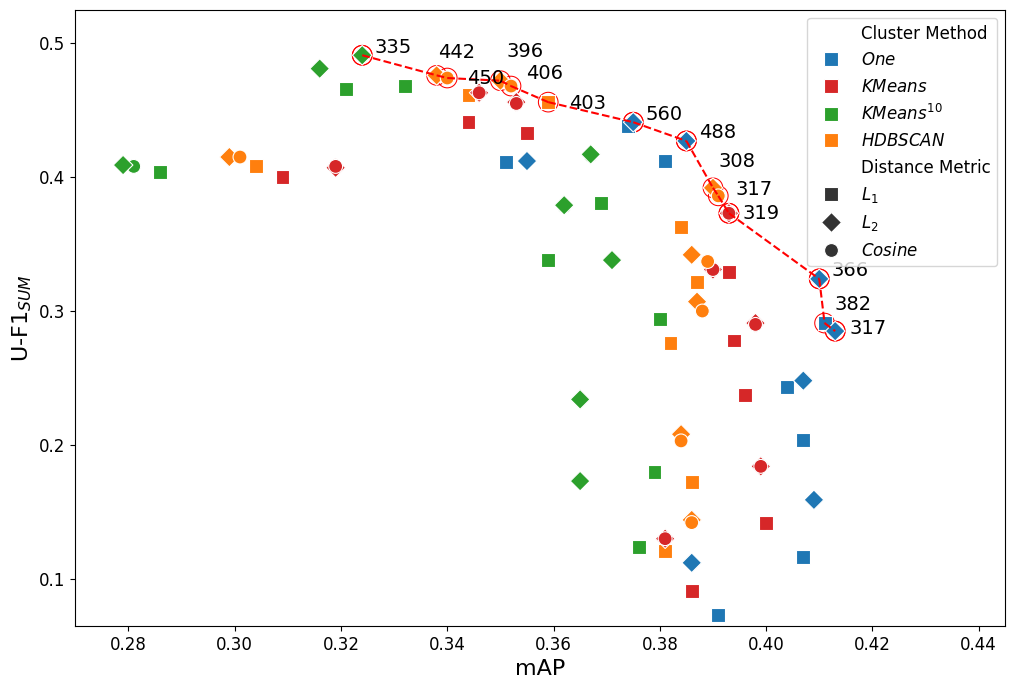

In [8]:
# Constants for the style of the plots
#STYLE_ORDER = ['$L_1$', '$L_2$', 'Cosine', '$L^{SDR}_1$', '$L^{SDR}_2$', 'Cosine$^{SDR}$', 'MSP', 'Energy', 'ODIN']
STYLE_ORDER = ['$L_1$', '$L_2$', '$Cosine$']
HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$']

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False

# Constants
USE_LIMS = True
XLIM = (0.27, 0.445)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.18)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.025, 0.35)
else:
    YLIM = (0.065, 0.525)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
# non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# # Extract the non-dominated points into a df
# df_non_dominated_cluster_methods = df_final.iloc[non_dominated_points]

df_non_dominated_cluster_methods, non_dominated_points = pareto_front(df_final, {
    'U-F1_(SUM)': 'max',
    'mAP': 'max',
    #'A-OSE': 'min',
    })


# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',
                hue='Cluster Method', hue_order=HUE_ORDER,
                style='Distance Metric', style_order=STYLE_ORDER,
                markers=MARKERS,
                s=MARKER_SIZE,
                #size='Confidence Threshold', sizes=(80, 300), #size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
#plt.ylabel(f'U-F1_$\{{WHICH_SUBSET}\}$)', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_cluster_methods_vanilla.pdf', bbox_inches='tight')
plt.show()

In [9]:
# Save df
df_non_dominated_cluster_methods.to_csv(Path(f"results/{WHICH_YOLO_VERSION}") / f'df_non_dominated_cluster_methods.csv', index=False)

### Figure 2: Comparison of distance methods with SDR

#### SDR only, then both non-dominated

In [10]:
# Obtain the SDR results
folders_to_consider = [
    Path(f"results/{WHICH_YOLO_VERSION}/fmap_method_SDR")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_cluster_methods_SDR = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_cluster_methods_SDR.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance Metric'})
df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})

# Obtaint the SDR non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_SDR = df_final.iloc[non_dominated_points]

# Save the df to csv
df_non_dominated_cluster_methods_SDR.to_csv(Path(f"results/{WHICH_YOLO_VERSION}") / f'df_non_dominated_cluster_methods_SDR.csv', index=False)

# Save the DF with another name
df_final_cluster_methods_SDR = df_final.copy()

print(df_final['Distance Metric'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/V9/fmap_method_SDR/20250529_124358_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_CosineIvis_KMeans_10.csv'), PosixPath('results/V9/fmap_method_SDR/20250528_225828_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1Ivis_KMeans.csv'), PosixPath('results/V9/fmap_method_SDR/20250528_225958_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1Ivis_KMeans_10.csv'), PosixPath('results/V9/fmap_method_SDR/20250529_124531_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_CosineIvis_HDBSCAN.csv'), PosixPath('results/V9/fmap_method_SDR/20250528_230131_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1Ivis_HDBSCAN.csv'), PosixPath('results/V9/fmap_method_SDR/20250529_124052_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_CosineIvis_one.csv'), PosixPath('results/V9/fmap_method_SDR/20250529_055039_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L2Ivis_HDBSCAN.csv'), PosixPath('results/V9/fmap_method_SDR/20250529_054906_202

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
91,$L^{SDR}_2$,$KMeans$,0.100,0.548,0.165,0.283,0.645,0.181,0.358,0.025,0.121,0.221,0.083,231,0.120,0.404
92,$L^{SDR}_2$,$KMeans$,0.050,0.536,0.219,0.305,0.572,0.208,0.355,0.043,0.142,0.213,0.106,258,0.132,0.447
93,$L^{SDR}_2$,$KMeans$,0.010,0.495,0.228,0.344,0.418,0.293,0.319,0.038,0.169,0.168,0.171,325,0.130,0.513
94,$L^{SDR}_2$,$KMeans$,0.005,0.468,0.270,0.338,0.351,0.325,0.303,0.052,0.170,0.145,0.205,372,0.128,0.508
95,$L^{SDR}_2$,$KMeans$,0.001,0.418,0.302,0.287,0.218,0.422,0.275,0.052,0.146,0.097,0.297,439,0.105,0.433


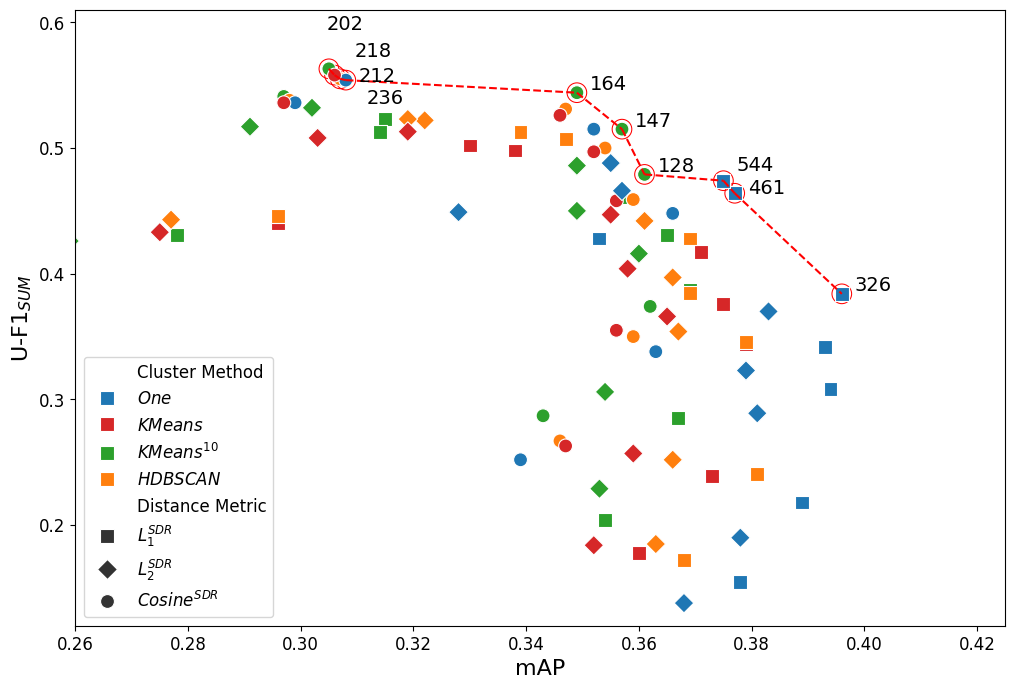

In [11]:
# Constants for the style of the plots
STYLE_ORDER = ['$L^{SDR}_1$', '$L^{SDR}_2$', '$Cosine^{SDR}$']
HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$']
OTHER_MARKERS = {
    '$L^{SDR}_1$': 's',
    '$L^{SDR}_2$': 'D',
    '$Cosine^{SDR}$': 'o',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.26, 0.425)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.12, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'


# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', hue='Cluster Method', style='Distance Metric',
                style_order=STYLE_ORDER,  hue_order=HUE_ORDER, 
                markers=OTHER_MARKERS,
                s=MARKER_SIZE,
                #size='Confidence Threshold', sizes=(80, 300), #size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_cluster_methods_SDR.pdf', bbox_inches='tight')
plt.show()

### Figure 3. Enhanced Unknonw Localization (EUL) with distance methods

In [12]:
# Obtain the SDR results
folders_to_consider = [
    Path(f"results/{WHICH_YOLO_VERSION}/fmap_method_EUL")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_cluster_methods_EUL = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_cluster_methods_EUL.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance Metric'})
df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})

# Rename the methods to have EUL name
normal_to_EUL = {
    '$L_1$': '$L^{EUL}_1$',
    '$L_2$': '$L^{EUL}_2$',
    '$Cosine$': '$Cosine^{EUL}$',
}
df_final['Distance Metric'] = df_final['Distance Metric'].replace(normal_to_EUL)

# Obtaint the SDR non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_EUL = df_final.iloc[non_dominated_points]

# Save the df to csv
df_non_dominated_cluster_methods_EUL.to_csv(Path(f"results/{WHICH_YOLO_VERSION}") / f'df_non_dominated_cluster_methods_EUL.csv', index=False)

# Save the DF with another name
df_final_cluster_methods_EUL = df_final.copy()

print(df_final['Distance Metric'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/V9/fmap_method_EUL/20250530_005259_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_Cosine_cl_stride_one.csv'), PosixPath('results/V9/fmap_method_EUL/20250529_194359_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1_cl_stride_one.csv'), PosixPath('results/V9/fmap_method_EUL/20250530_005734_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_Cosine_cl_stride_HDBSCAN.csv'), PosixPath('results/V9/fmap_method_EUL/20250530_005430_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_Cosine_cl_stride_KMeans.csv'), PosixPath('results/V9/fmap_method_EUL/20250529_221729_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L2_cl_stride_KMeans_10.csv'), PosixPath('results/V9/fmap_method_EUL/20250529_221551_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L2_cl_stride_KMeans.csv'), PosixPath('results/V9/fmap_method_EUL/20250529_194703_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_L1_cl_stride_KMeans_10.csv'), PosixPath('results/V

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
91,$L^{EUL}_1$,$HDBSCAN$,0.100,0.609,0.179,0.248,0.236,0.263,0.387,0.030,0.108,0.090,0.134,278,0.140,0.356
92,$L^{EUL}_1$,$HDBSCAN$,0.050,0.597,0.181,0.257,0.237,0.282,0.384,0.030,0.113,0.092,0.147,321,0.157,0.370
93,$L^{EUL}_1$,$HDBSCAN$,0.010,0.553,0.215,0.280,0.233,0.352,0.359,0.039,0.129,0.094,0.201,403,0.152,0.409
94,$L^{EUL}_1$,$HDBSCAN$,0.005,0.529,0.216,0.277,0.218,0.380,0.344,0.039,0.131,0.091,0.233,441,0.143,0.408
95,$L^{EUL}_1$,$HDBSCAN$,0.001,0.472,0.255,0.246,0.167,0.462,0.304,0.046,0.119,0.074,0.312,527,0.124,0.365


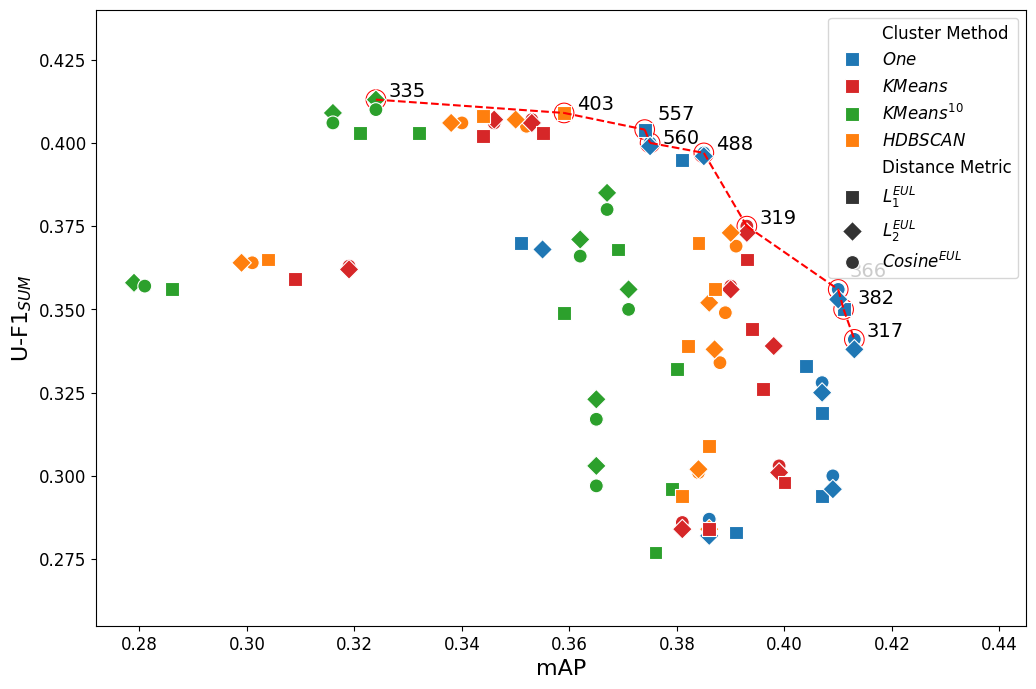

In [13]:
# Constants for the style of the plots
STYLE_ORDER = ['$L^{EUL}_1$', '$L^{EUL}_2$', '$Cosine^{EUL}$']
HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$']
OTHER_MARKERS = {
    '$L^{EUL}_1$': 's',
    '$L^{EUL}_2$': 'D',
    '$Cosine^{EUL}$': 'o',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.272, 0.445)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.255, 0.44)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', hue='Cluster Method', style='Distance Metric',
                s=MARKER_SIZE,
                hue_order=HUE_ORDER, style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                #size='Confidence Threshold', sizes=(80, 300), #size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_cluster_methods_EUL.pdf', bbox_inches='tight')
plt.show()

In [14]:
df_non_dominated_cluster_methods_EUL

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
3,$Cosine^{EUL}$,$One$,0.100,0.637,0.176,0.243,0.232,0.255,0.413,0.038,0.098,0.083,0.119,317,0.147,0.341
4,$Cosine^{EUL}$,$One$,0.050,0.636,0.176,0.253,0.236,0.273,0.410,0.031,0.103,0.085,0.130,366,0.163,0.356
5,$Cosine^{EUL}$,$One$,0.010,0.611,0.205,0.274,0.234,0.330,0.385,0.027,0.123,0.093,0.179,488,0.157,0.397
6,$Cosine^{EUL}$,$One$,0.005,0.598,0.208,0.272,0.222,0.351,0.375,0.035,0.128,0.093,0.207,560,0.150,0.400
12,$L^{EUL}_1$,$One$,0.050,0.635,0.148,0.245,0.231,0.260,0.411,0.026,0.105,0.087,0.134,382,0.172,0.350
14,$L^{EUL}_1$,$One$,0.005,0.588,0.205,0.274,0.225,0.352,0.374,0.035,0.130,0.094,0.213,557,0.155,0.404
28,$Cosine^{EUL}$,$KMeans$,0.050,0.608,0.181,0.264,0.241,0.291,0.393,0.034,0.111,0.090,0.145,319,0.155,0.375
37,$L^{EUL}_2$,$KMeans^{10}$,0.010,0.509,0.222,0.281,0.227,0.369,0.324,0.041,0.132,0.095,0.218,335,0.149,0.413
93,$L^{EUL}_1$,$HDBSCAN$,0.010,0.553,0.215,0.280,0.233,0.352,0.359,0.039,0.129,0.094,0.201,403,0.152,0.409


### Table and Figure 4. Non-dominated solutions with distance methods

#### Figure Vanilla + SDR + EUL

In [15]:
# Collect the non-dominated points of the cluster methods.
# Name them as f"Non-dominated {name}$"" and add them to the df
# The name will depend on where they came from. If just cluster methods, then it will be Non-dominated vanilla
# If they come from SDR, then it will be Non-dominated SDR

# Vanilla
df_non_dominated_cluster_methods_new_names = df_non_dominated_cluster_methods.copy()
df_non_dominated_cluster_methods_new_names['Type'] = 'Non-dominated vanilla'
#df_non_dominated_cluster_methods_new_names['Cluster Method'] = 'Non-dominated vanilla'

# SDR
df_non_dominated_cluster_methods_SDR_new_names = df_non_dominated_cluster_methods_SDR.copy()
df_non_dominated_cluster_methods_SDR_new_names['Type'] = 'Non-dominated SDR'
#df_non_dominated_cluster_methods_SDR_new_names['Cluster Method'] = 'Non-dominated SDR'

# EUL
df_non_dominated_cluster_methods_EUL_new_names = df_non_dominated_cluster_methods_EUL.copy()
df_non_dominated_cluster_methods_EUL_new_names['Type'] = 'Non-dominated EUL'
#df_non_dominated_cluster_methods_EUL_new_names['Cluster Method'] = 'Non-dominated EUL'

# Concatenate the dataframes
df_non_dominated_all_cluster_methods = pd.concat(
    [df_non_dominated_cluster_methods_new_names, df_non_dominated_cluster_methods_SDR_new_names, df_non_dominated_cluster_methods_EUL_new_names]).reset_index(drop=True)

# Compute the non-dominated points for the final dataframe
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_non_dominated_all_cluster_methods, WHICH_SUBSET)
# # Extract the non-dominated points into a df
# df_non_dominated_all_cluster_methods = df_non_dominated_all_cluster_methods.iloc[non_dominated_points]

df_final = df_non_dominated_all_cluster_methods.copy()
df_final.head()

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type
0,$Cosine$,$One$,0.100,0.637,0.155,0.204,0.649,0.121,0.413,0.030,0.081,0.194,0.051,317,0.147,0.285,Non-dominated vanilla
1,$Cosine$,$One$,0.050,0.636,0.154,0.225,0.570,0.140,0.410,0.023,0.099,0.187,0.067,366,0.163,0.324,Non-dominated vanilla
2,$Cosine$,$One$,0.010,0.611,0.201,0.286,0.431,0.214,0.385,0.037,0.141,0.165,0.123,488,0.157,0.427,Non-dominated vanilla
3,$Cosine$,$One$,0.005,0.598,0.204,0.293,0.366,0.244,0.375,0.036,0.148,0.145,0.153,560,0.150,0.441,Non-dominated vanilla
4,$L_1$,$HDBSCAN$,0.010,0.553,0.211,0.305,0.406,0.244,0.359,0.038,0.151,0.155,0.148,403,0.152,0.456,Non-dominated vanilla


/tmp/ipykernel_269230/1142802676.py:42: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


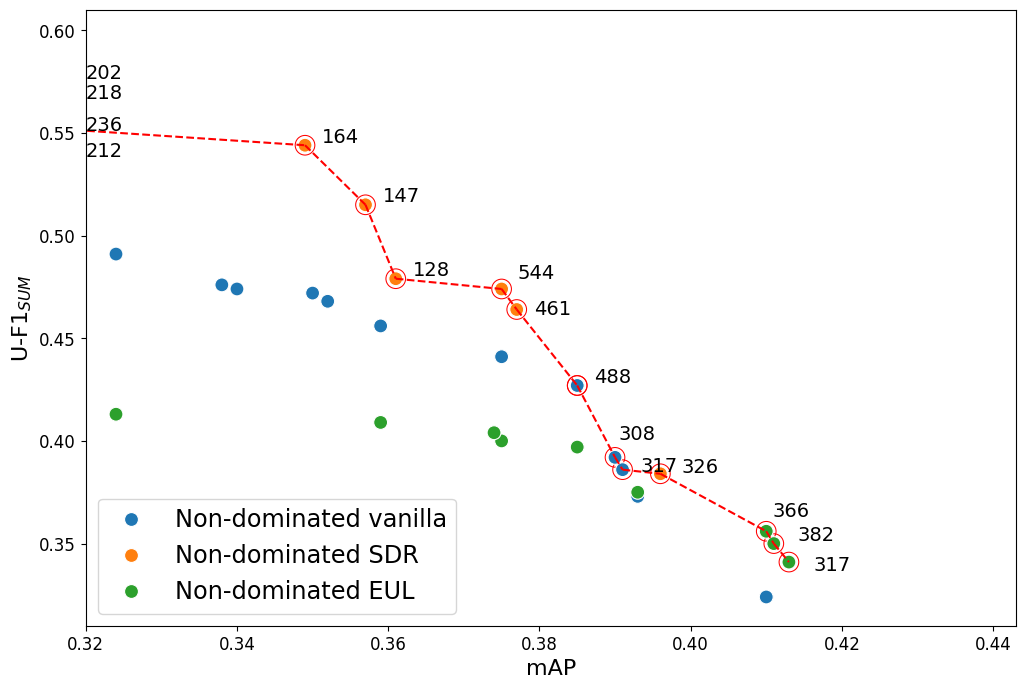

In [16]:
# Constants for the style of the plots
STYLE_ORDER = ['Non-dominated vanilla', 'Non-dominated SDR','Non-dominated EUL']
HUE_ORDER = ['Non-dominated vanilla', 'Non-dominated SDR', 'Non-dominated EUL']
OTHER_MARKERS = {
    'Non-dominated vanilla': '*',
    'Non-dominated SDR': 'X',
    'Non-dominated EUL': 'P',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.32, 0.443)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.096, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.19, 0.405)
else:
    YLIM = (0.31, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[1], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #style='Distance',
                hue='Type',
                s=MARKER_SIZE,
                hue_order=HUE_ORDER, style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                #size='Confidence Threshold', sizes=(80, 150), #size_norm=(0.01, 0.5),
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Type', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND, loc="lower left")
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_cluster_methods_non-dominated_comparison_normal_SDR_EUL.pdf', bbox_inches='tight')
plt.show()

#### Figure Vanilla + SDR + EUL, Prec vs Recall

In [17]:
df_non_dominated_all_cluster_methods.head()

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type
0,$Cosine$,$One$,0.100,0.637,0.155,0.204,0.649,0.121,0.413,0.030,0.081,0.194,0.051,317,0.147,0.285,Non-dominated vanilla
1,$Cosine$,$One$,0.050,0.636,0.154,0.225,0.570,0.140,0.410,0.023,0.099,0.187,0.067,366,0.163,0.324,Non-dominated vanilla
2,$Cosine$,$One$,0.010,0.611,0.201,0.286,0.431,0.214,0.385,0.037,0.141,0.165,0.123,488,0.157,0.427,Non-dominated vanilla
3,$Cosine$,$One$,0.005,0.598,0.204,0.293,0.366,0.244,0.375,0.036,0.148,0.145,0.153,560,0.150,0.441,Non-dominated vanilla
4,$L_1$,$HDBSCAN$,0.010,0.553,0.211,0.305,0.406,0.244,0.359,0.038,0.151,0.155,0.148,403,0.152,0.456,Non-dominated vanilla


/tmp/ipykernel_269230/4057395491.py:50: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x=x_col, y=y_col,


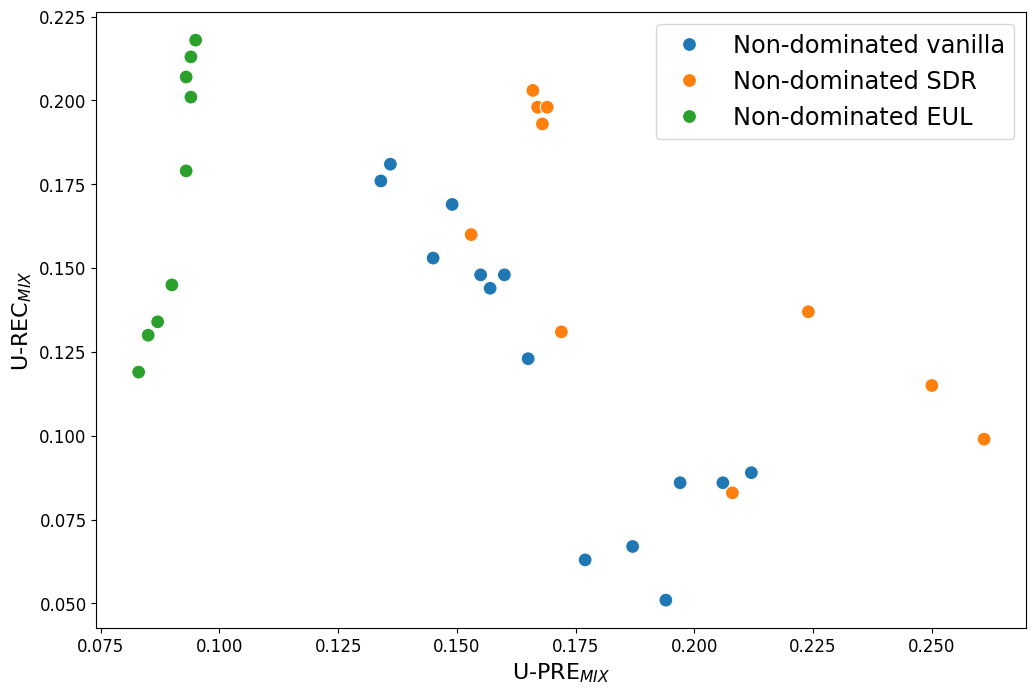

In [18]:
# Constants for the style of the plots
STYLE_ORDER = ['Non-dominated vanilla', 'Non-dominated SDR','Non-dominated EUL']
HUE_ORDER = ['Non-dominated vanilla', 'Non-dominated SDR', 'Non-dominated EUL']
OTHER_MARKERS = {
    'Non-dominated vanilla': '*',
    'Non-dominated SDR': 'X',
    'Non-dominated EUL': 'P',
}

df_final = df_non_dominated_all_cluster_methods.copy()

# Configure plot
WHICH_SUBSET_FOR_PREC_VS_RECALL = 'CMIX'
HIGHLIGHT_NON_DOMINATED_POINTS = False
CONNECT_NON_DOMINATED_POINTS = False
ADD_TEXT_VALUES = False
WHICH_TEXT_TO_ADD = 'Confidence Threshold'
ADD_TEXT_TO_ALL = False  # If false, only to non-dominated points
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = False
which_text_to_add = 'A-OSE'
x_col = f'U-PRE_({WHICH_SUBSET_FOR_PREC_VS_RECALL})'
y_col = f'U-REC_({WHICH_SUBSET_FOR_PREC_VS_RECALL})'

# Constants
XLIM = (0.32, 0.445)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.096, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.19, 0.405)
else:
    YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[1], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x=x_col, y=y_col, 
                #style='Distance',
                hue='Type',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Type', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
# Remove the first letter of the string WHICH_SUBSET_FOR_PREC_VS_RECALL
x_col_label = x_col.replace('_', '$_').replace('(C', '{').replace(')', '}$')
y_col_label = y_col.replace('_', '$_').replace('(C', '{').replace(')', '}$')
plt.xlabel(x_col_label, fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(y_col_label, fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_TEXT_VALUES:
    if ADD_TEXT_TO_ALL:
        add_text_to_non_dominated_points(ax, df_final, [x for x in range(len(df_final))], x_col, y_col, WHICH_TEXT_TO_ADD, FONTSIZE_AOSE)
    else:
        add_text_to_non_dominated_points(ax, df_final, non_dominated_points, x_col, y_col, WHICH_TEXT_TO_ADD, FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND, loc="best")
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_UNK_PREC_vs_RECALL_{WHICH_SUBSET_FOR_PREC_VS_RECALL}_cluster_methods_non-dominated_comparison_normal_SDR_EUL.pdf', bbox_inches='tight')
plt.show()

#### Table Vanilla + SDR + EUL

In [19]:
df_non_dominated_all_cluster_methods.head()

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type
0,$Cosine$,$One$,0.100,0.637,0.155,0.204,0.649,0.121,0.413,0.030,0.081,0.194,0.051,317,0.147,0.285,Non-dominated vanilla
1,$Cosine$,$One$,0.050,0.636,0.154,0.225,0.570,0.140,0.410,0.023,0.099,0.187,0.067,366,0.163,0.324,Non-dominated vanilla
2,$Cosine$,$One$,0.010,0.611,0.201,0.286,0.431,0.214,0.385,0.037,0.141,0.165,0.123,488,0.157,0.427,Non-dominated vanilla
3,$Cosine$,$One$,0.005,0.598,0.204,0.293,0.366,0.244,0.375,0.036,0.148,0.145,0.153,560,0.150,0.441,Non-dominated vanilla
4,$L_1$,$HDBSCAN$,0.010,0.553,0.211,0.305,0.406,0.244,0.359,0.038,0.151,0.155,0.148,403,0.152,0.456,Non-dominated vanilla


In [20]:
df_non_dominated_all_cluster_methods.columns

Index(['Distance Metric', 'Cluster Method', 'Confidence Threshold',
       'mAP_(VOC_test)', 'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)',
       'U-REC_(COOD)', 'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)',
       'U-REC_(CMIX)', 'A-OSE', 'WI-08', 'U-F1_(SUM)', 'Type'],
      dtype='object')

In [21]:
# Make a table with the non-dominated points. 
# First create the Method column, and put the "FMap" string in it for all the rows
df_table = df_non_dominated_all_cluster_methods.copy()
df_table['Method'] = 'FMap'
# Rename the conf_thr column to "Confidence Threshold"
df_table = df_table.rename(columns={'conf_thr_test': 'Confidence Threshold'})
# Reorder the rows by the desired column OR using a list of methods 'Distance Metric', 'Cluster Method', 'conf_thr_test', 'mAP_(VOC_test)', 
#   'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP',
#   'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'A-OSE', 'WI-08', 'U-F1_(SUM)', 'Type'
#df_table = df_table.sort_values(by='Distance Metric', ascending=True)
df_table["Distance Metric"] = pd.Categorical(df_table["Distance Metric"], categories=ORDER_FOR_LATEX_ROWS, ordered=True)
df_table = df_table.sort_values(by=["Distance Metric", "mAP_(VOC_test)"], ascending=[True, True])

# Reorder the columns
df_table = df_table[COLUMNS_TO_ORDER_FOR_LATEX]
# Remove the Method column
df_table = df_table.drop(columns=['Method'])

# Save the table to a latex file and to a latex string
LOCAL_LATEX_PARAMS = LATEX_PARAMS.copy()
#LOCAL_LATEX_PARAMS['column_format'] = 'c'*(len(df_table.columns)-1)
# Remove the column Method from header
LOCAL_COLUMNS_FOR_LATEX = COLUMNS_FOR_LATEX.copy()
LOCAL_COLUMNS_FOR_LATEX.remove('Method')
latex_str = df_table.to_latex(header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)
df_table.to_latex(RQ1_FIGURES_FOLDER / 'rq1.tex', header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)

# Show
df_table.head()

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
4,$L_1$,$HDBSCAN$,0.010,0.553,0.211,0.305,0.406,0.244,0.359,0.038,0.151,0.155,0.148,403,0.152
8,$L_1$,$One$,0.050,0.635,0.149,0.198,0.569,0.120,0.411,0.018,0.093,0.177,0.063,382,0.172
7,$L_2$,$KMeans^{10}$,0.010,0.509,0.221,0.333,0.401,0.285,0.324,0.038,0.158,0.149,0.169,335,0.149
16,$L_2$,$HDBSCAN$,0.005,0.539,0.219,0.321,0.352,0.295,0.338,0.041,0.155,0.136,0.181,442,0.140
15,$L_2$,$HDBSCAN$,0.010,0.555,0.217,0.318,0.415,0.258,0.350,0.040,0.154,0.160,0.148,396,0.144


In [22]:
# def format_latex_str(latex_str: str, mark_greater_values: Dict[str, float], mark_lower_values: Dict[str, float]) -> str:
#     # Split the string into lines
#     lines = latex_str.splitlines()
#     # Add the midrules
#     lines.insert(10, '\\midrule')
#     lines.insert(17, '\\midrule')
#     lines.insert(24, '\\midrule')
#     # Join the lines back into a single string    
#     final_latex_str = '\n'.join(lines)
#     # Mark in bold and underline the greatest value of each column
#     for col, value in mark_greater_values.items():
#         # For each value, search for it in the string and change it to bold
#         final_latex_str = final_latex_str.replace(str(value), '\\underline{\\textbf{' + str(value) + '}}')
#     for col, value in mark_lower_values.items():
#         # For each value, search for it in the string and change it to bold
#         final_latex_str = final_latex_str.replace(str(value), '\\textbf{' + str(value) + '}')
#     return final_latex_str

# max_values, min_values = obtain_best_values_of_columns(normal_df, columns_to_search_max=FINAL_COLUMNS[2:-2], columns_to_search_min=FINAL_COLUMNS[-2:])
# final_latex_str = format_latex_str(latex_str, max_values, min_values)
# # Save the final string to the file
# with open(NORMAL_TEX_PATH, 'w') as f:
#     f.write(final_latex_str)

## RQ2. Post-hoc methods

### Option 1. Post-hoc methods one figure and then non-dominated of post-hoc against cluster methods non-dominated solutions

First the post-hoc methods non-dominated solutions

In [23]:
# Create folders
#WHICH_YOLO_VERSION = "V12"

In [24]:
folders_to_consider = [
    Path(f"results/{WHICH_YOLO_VERSION}/logits_methods")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_logits = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_logits.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})

# Obtain the logits non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_logits = df_final.iloc[non_dominated_points]

# Save the df to csv
df_non_dominated_logits.to_csv(Path(f"results/{WHICH_YOLO_VERSION}") / f'df_non_dominated_logits.csv', index=False)

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())
df_final.head()

[PosixPath('results/V9/logits_methods/20250611_205115_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_MSP.csv'), PosixPath('results/V9/logits_methods/20250611_211749_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_ODIN.csv'), PosixPath('results/V9/logits_methods/20250611_211619_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_Energy.csv')]
['MSP' 'ODIN' 'Energy']
['-']


,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
0,MSP,-,0.45,0.679,0.170,0.201,0.859,0.114,0.417,0.037,0.067,0.276,0.038,104,0.079,0.268
1,MSP,-,0.30,0.694,0.170,0.269,0.763,0.164,0.437,0.037,0.100,0.272,0.061,112,0.081,0.369
2,MSP,-,0.15,0.715,0.232,0.330,0.638,0.223,0.437,0.063,0.148,0.280,0.101,121,0.086,0.478
3,MSP,-,0.10,0.715,0.232,0.353,0.597,0.251,0.440,0.063,0.167,0.267,0.121,124,0.086,0.520
4,MSP,-,0.05,0.715,0.232,0.367,0.528,0.281,0.440,0.063,0.174,0.226,0.142,131,0.086,0.541


/tmp/ipykernel_269230/431983111.py:52: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


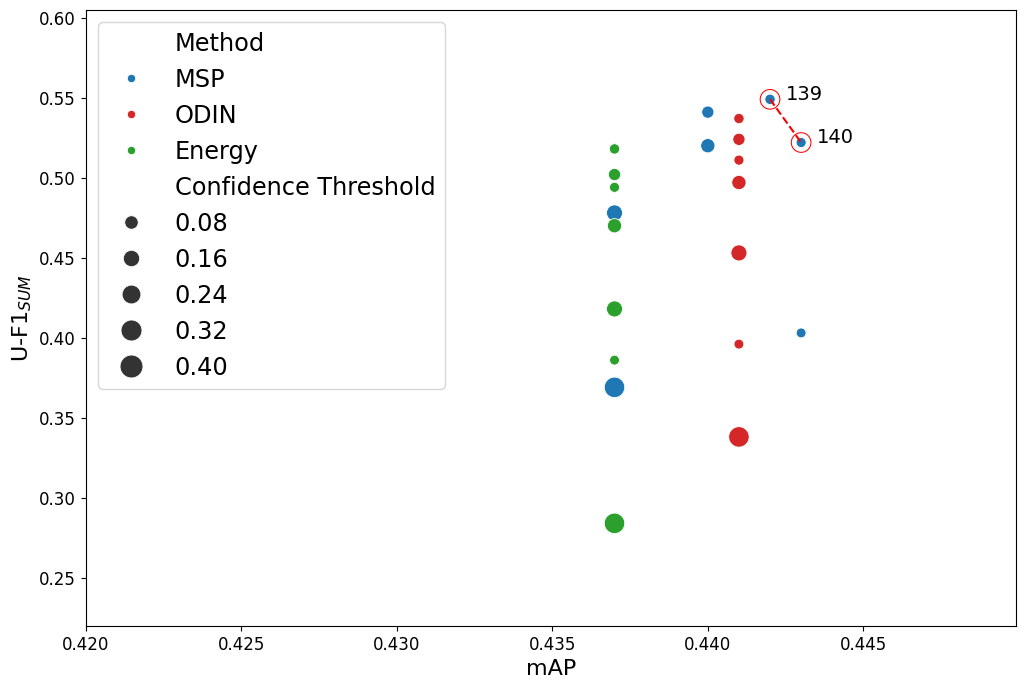

In [25]:
# Constants for the style of the plots
STYLE_ORDER = ['MSP', 'ODIN', 'Energy']
HUE_ORDER = ['MSP', 'ODIN', 'Energy']
OTHER_MARKERS = {
    'MSP': 'o',
    'ODIN': 'o',
    'Energy': 'o',
}
#HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$', '$ND_{prev}$']

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True
AUTOMATIC_TEXT_ADJUSTMENT = False

# Constants
XLIM = (0.42, 0.4499)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.027, 0.195)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.22, 0.605)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'  # You can use 'small', 'medium', 'large', 'x-large', etc.
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
# non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# # Extract the non-dominated points into a df
# df_non_dominated_cluster_methods_SDR_and_logits = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[4], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                hue='Method',  hue_order=HUE_ORDER, 
                #style='Method', style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                #s=MARKER_SIZE,
                size='Confidence Threshold', sizes=(50, 300), #size_norm=(0.001, 0.5),
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE, AUTOMATIC_TEXT_ADJUSTMENT,
                                     offset_pos=0.0005, offset_neg=-0.007)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(RQ2_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_best_cluster_methods_against_logits.pdf', bbox_inches='tight')
plt.show()

Now the non-dominated solutions of post-hoc against non-dominated solutions from cluster methods

In [26]:
# Collect the non-dominated points of the cluster methods and post hoc
# Name cluster methods as them as f"Non-dominated distance"" and add them to the df
# Name the post hoc methods as Non-dominated post-hoc and add them to the df

# Cluster methods
# All
df_non_dominated_all_cluster_methods_new_names = df_non_dominated_all_cluster_methods.copy()
df_non_dominated_all_cluster_methods_new_names['Method'] = 'FMap'
df_non_dominated_all_cluster_methods_new_names['Type'] = 'Non-dominated feature'

# df_non_dominated_cluster_methods_new_names['Method'] = 'FMap'
# df_non_dominated_cluster_methods_new_names['Type'] = 'Non-dominated feature'
# #df_non_dominated_cluster_methods_new_names['Cluster Method'] = 'Non-dominated feature'
# # SDR
# df_non_dominated_cluster_methods_SDR_new_names = df_non_dominated_cluster_methods_SDR.copy()
# df_non_dominated_cluster_methods_new_names['Method'] = 'FMap'
# df_non_dominated_cluster_methods_SDR_new_names['Type'] = 'Non-dominated feature'
# #df_non_dominated_cluster_methods_SDR_new_names['Cluster Method'] = 'Non-dominated feature'
# # EUL
# df_non_dominated_cluster_methods_EUL_new_names = df_non_dominated_cluster_methods_EUL.copy()
# df_non_dominated_cluster_methods_new_names['Method'] = 'FMap'
# df_non_dominated_cluster_methods_EUL_new_names['Type'] = 'Non-dominated feature'
#df_non_dominated_cluster_methods_EUL_new_names['Cluster Method'] = 'Non-dominated feature'

# Post-hoc
df_non_dominated_logits_new_names = df_non_dominated_logits.copy()
df_non_dominated_logits_new_names['Type'] = 'Non-dominated post-hoc'
df_non_dominated_logits_new_names['Distance Metric'] = '-'
#df_non_dominated_logits_new_names['Cluster Method'] = 'Non-dominated post-hoc'

# Concatenate the dataframes
df_non_dominated_distance_vs_posthoc_methods = pd.concat(
    [#df_non_dominated_cluster_methods_new_names, df_non_dominated_cluster_methods_SDR_new_names, df_non_dominated_cluster_methods_EUL_new_names,
        df_non_dominated_all_cluster_methods_new_names,
     df_non_dominated_logits_new_names]).reset_index(drop=True)

# Rename the Distance to Method
#df_non_dominated_distance_vs_posthoc_methods = df_non_dominated_distance_vs_posthoc_methods.rename(columns={'Distance': 'Method'})

df_final = df_non_dominated_distance_vs_posthoc_methods.copy()
df_final.tail()

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type,Method
36,$Cosine^{EUL}$,$KMeans$,0.050,0.608,0.181,0.264,0.241,0.291,0.393,0.034,0.111,0.090,0.145,319,0.155,0.375,Non-dominated feature,FMap
37,$L^{EUL}_2$,$KMeans^{10}$,0.010,0.509,0.222,0.281,0.227,0.369,0.324,0.041,0.132,0.095,0.218,335,0.149,0.413,Non-dominated feature,FMap
38,$L^{EUL}_1$,$HDBSCAN$,0.010,0.553,0.215,0.280,0.233,0.352,0.359,0.039,0.129,0.094,0.201,403,0.152,0.409,Non-dominated feature,FMap
39,-,-,0.010,0.723,0.276,0.370,0.378,0.363,0.442,0.078,0.179,0.155,0.212,139,0.087,0.549,Non-dominated post-hoc,MSP
40,-,-,0.005,0.725,0.276,0.354,0.319,0.397,0.443,0.078,0.168,0.127,0.247,140,0.088,0.522,Non-dominated post-hoc,MSP


/tmp/ipykernel_269230/1680996228.py:50: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


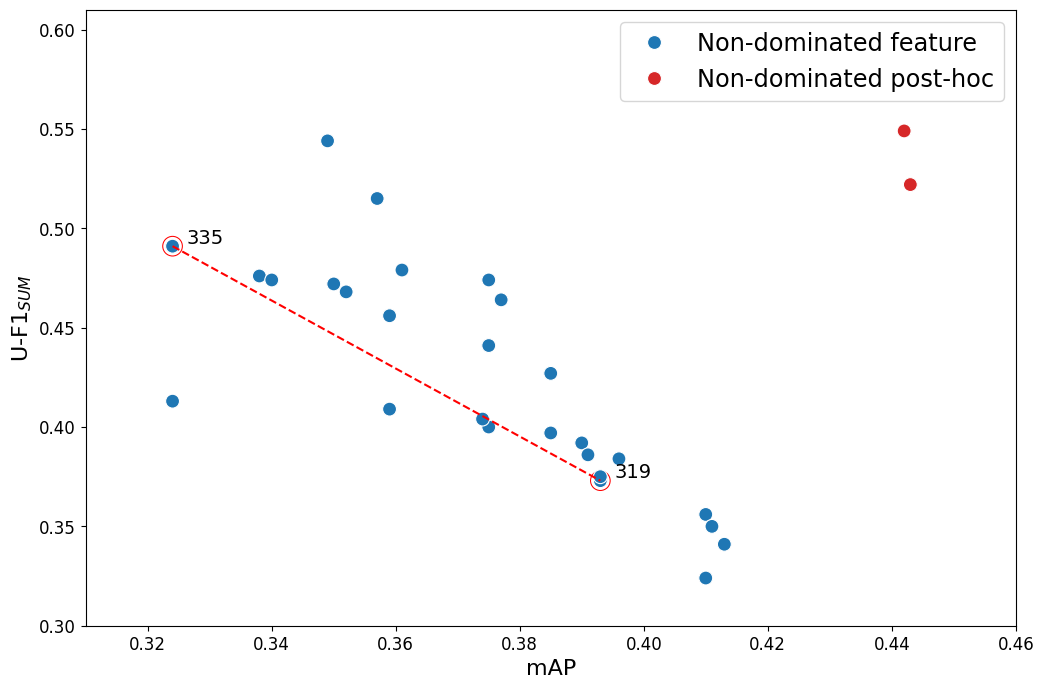

In [27]:
# Constants for the style of the plots
#STYLE_ORDER = ['Non-dominated feature', 'Non-dominated post-hoc']
HUE_ORDER = ['Non-dominated feature', 'Non-dominated post-hoc']
OTHER_MARKERS = {
    'Non-dominated vanilla': '*',
    'Non-dominated SDR': 'X',
    'Non-dominated EUL': 'P',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True

# Constants
USE_LIMS = True
XLIM = (0.31, 0.46)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.098, 0.198)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
# non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# # Extract the non-dominated points into a df
# df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #style='Distance',
                hue='Type',
                s=MARKER_SIZE, hue_order=HUE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND, loc="best")
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ2_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_distance_vs_posthoc:methods_non-dominated_comparison.pdf', bbox_inches='tight')
plt.show()

#### Figure of ALL post-hoc methods against non-dominated cluster solutions

In [28]:
# Cluster methods
# Rename the Type column to Method
df_non_dominated_all_cluster_methods_new_names = df_non_dominated_all_cluster_methods.copy()
df_non_dominated_all_cluster_methods_new_names = df_non_dominated_all_cluster_methods_new_names.rename(columns={'Type': 'Method'})
df_non_dominated_all_cluster_methods_new_names["Method"].replace({'Non-dominated vanilla': 'Non-dominated FMap$^{vanilla}$'}, inplace=True)
df_non_dominated_all_cluster_methods_new_names["Method"].replace({'Non-dominated SDR': 'Non-dominated FMap$^{SDR}$'}, inplace=True)
df_non_dominated_all_cluster_methods_new_names["Method"].replace({'Non-dominated EUL': 'Non-dominated FMap$^{EUL}$'}, inplace=True)
df_non_dominated_all_cluster_methods_new_names

# Change the column name cluster_method to Cluster Method and Method to Distance. Create the column of "Distance Metric" with a "-".
df_final = df_logits.copy()
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})
df_final['Distance Metric'] = '-'
df_final

# Concatenate the dataframes
df_non_dominated_distance_vs_all_posthoc_methods = pd.concat([df_final, df_non_dominated_all_cluster_methods_new_names]).reset_index(drop=True)

df_final = df_non_dominated_distance_vs_all_posthoc_methods.copy()
df_final.head()

,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Distance Metric
0,MSP,-,0.45,0.679,0.170,0.201,0.859,0.114,0.417,0.037,0.067,0.276,0.038,104,0.079,0.268,-
1,MSP,-,0.30,0.694,0.170,0.269,0.763,0.164,0.437,0.037,0.100,0.272,0.061,112,0.081,0.369,-
2,MSP,-,0.15,0.715,0.232,0.330,0.638,0.223,0.437,0.063,0.148,0.280,0.101,121,0.086,0.478,-
3,MSP,-,0.10,0.715,0.232,0.353,0.597,0.251,0.440,0.063,0.167,0.267,0.121,124,0.086,0.520,-
4,MSP,-,0.05,0.715,0.232,0.367,0.528,0.281,0.440,0.063,0.174,0.226,0.142,131,0.086,0.541,-


/tmp/ipykernel_269230/2046010501.py:49: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


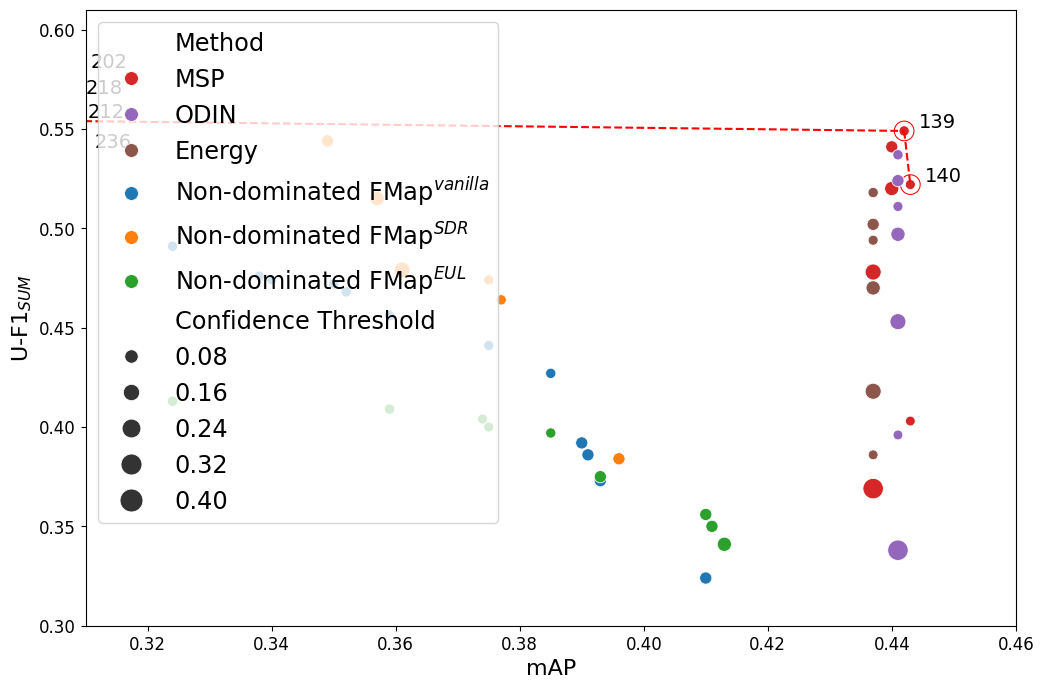

In [29]:
# Constants for the style of the plots
HUE_ORDER = ['MSP' ,'ODIN', 'Energy', 'Non-dominated FMap$^{vanilla}$', 'Non-dominated FMap$^{SDR}$', 'Non-dominated FMap$^{EUL}$']
# OTHER_MARKERS = {
#     'Non-dominated vanilla': '*',
#     'Non-dominated SDR': 'X',
#     'Non-dominated EUL': 'P',
# }

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.31, 0.46)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.098, 0.198)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
#Y_COL = f'U-PRE_(COOD)'
Y_COL = f'U-F1_({WHICH_SUBSET})'
_, non_dominated_points = pareto_front(df_final, {'mAP': 'max', Y_COL: 'max'})

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [ palette[3], palette[4], palette[5], palette[0], palette[1], palette[2], palette[6], palette[7], palette[8], palette[9]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #y=Y_COL, 
                #style='Distance',
                hue='Method',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                #style_order=STYLE_ORDER,
                #markers=OTHER_MARKERS,
                size='Confidence Threshold', sizes=(50, 300), #size_norm=(0.001, 0.5),
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)
    #highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', Y_COL, MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)
    #add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', Y_COL, COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND, loc="best")
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ2_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_distance_non-dominated_vs_all_posthoc_.pdf', bbox_inches='tight')
plt.show()

## RQ3. Fusion

AQUI ES IMPORTANTE TENER UNA FIGURA DONDE SE VEA QUE USAR MSP es casi lo mismo que MSP + post-hoc method

#### Option 1: Obtain first the non-dominated solutions of the fusion methods, then compare them

##### Fusion without simple MSP

So first the non-dominated solutions of the fusion methods

In [30]:
folders_to_consider = [
    Path(f"results/{WHICH_YOLO_VERSION}/fusion_methods")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_fusion_methods = format_df(df, columns_to_keep=FINAL_COLUMNS_FUSION)
df_fusion_methods.reset_index(drop=True, inplace=True)
df_final = df_fusion_methods.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'fusion_strat': 'Fusion Strategy'})
df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})

# Obtain the logits non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_fusion_methods = df_final.iloc[non_dominated_points]

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/V9/fusion_methods/20250531_041935_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-L1_cl_stride.csv'), PosixPath('results/V9/fusion_methods/20250530_195704_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-ODIN.csv'), PosixPath('results/V9/fusion_methods/20250531_122045_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-Cosine_cl_stride-CosineIvis.csv'), PosixPath('results/V9/fusion_methods/20250531_042105_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-L1Ivis.csv'), PosixPath('results/V9/fusion_methods/20250530_200007_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-CosineIvis.csv'), PosixPath('results/V9/fusion_methods/20250531_121607_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-ODIN.csv'), PosixPath('results/V9/fusion_methods/20250530_195535_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-Energy.csv'), PosixPath('results/V9/fusion_me

,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,Fusion Strategy,U-F1_(SUM)
187,MSP-ODIN,-,0.100,0.748,0.084,0.050,0.589,0.026,0.492,0.045,0.043,0.327,0.023,392,0.145,or,0.093
188,MSP-ODIN,-,0.050,0.748,0.084,0.059,0.520,0.031,0.494,0.045,0.052,0.304,0.028,475,0.159,or,0.111
189,MSP-ODIN,-,0.010,0.771,0.084,0.076,0.363,0.042,0.515,0.045,0.069,0.227,0.041,728,0.157,or,0.145
190,MSP-ODIN,-,0.005,0.776,0.084,0.076,0.289,0.044,0.519,0.045,0.077,0.197,0.048,890,0.151,or,0.153
191,MSP-ODIN,-,0.001,0.782,0.084,0.084,0.182,0.054,0.526,0.045,0.081,0.122,0.061,1348,0.128,or,0.165


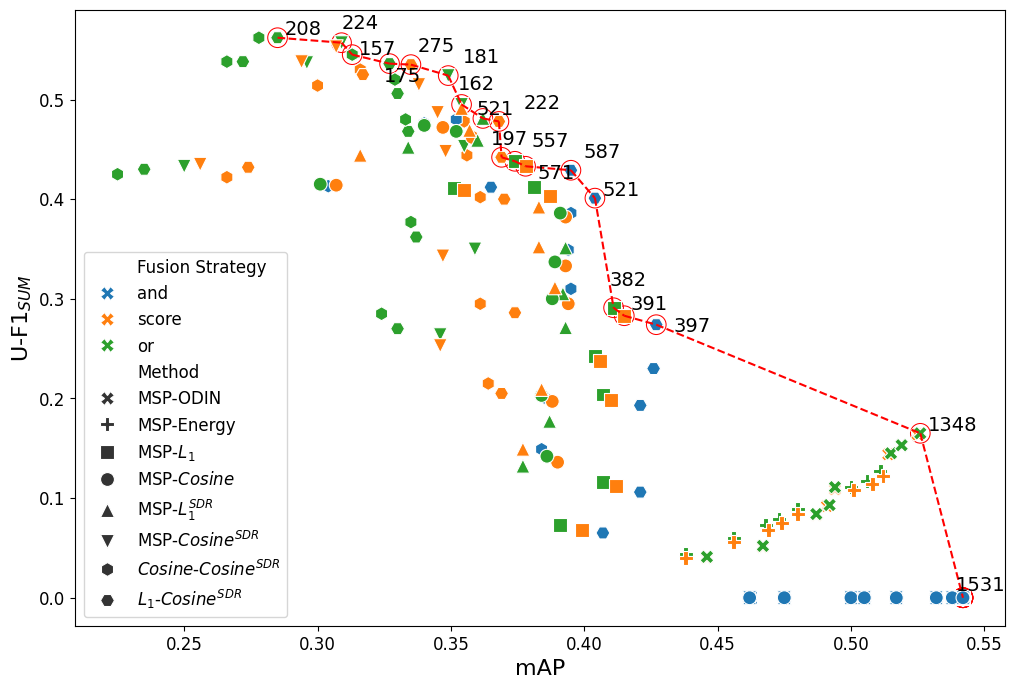

In [31]:
# Constants for the style of the plots
#HUE_ORDER = ['-', '$HDBSCAN$', '$KMeans^{10}$-$HDBSCAN$']
STYLE_ORDER = ['MSP-ODIN', 'MSP-Energy', 'MSP-$L_1$', 'MSP-$Cosine$', 'MSP-$L^{SDR}_1$', 'MSP-$Cosine^{SDR}$', '$Cosine$-$Cosine^{SDR}$', '$L_1$-$Cosine^{SDR}$'] #, 'MSP']
OTHER_MARKERS = {
    'MSP-ODIN': 'X', # o
    'MSP-Energy': 'P',  #s
    'MSP-$L_1$': 's',
    'MSP-$Cosine$': 'o',
    'MSP-$L^{SDR}_1$': '^',#'d',
    'MSP-$Cosine^{SDR}$': 'v',#'*',
    '$Cosine$-$Cosine^{SDR}$': 'h',
    '$L_1$-$Cosine^{SDR}$': 'H',
    #'MSP': '*',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = False

# Constants
XLIM = (0.26, 0.515)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.205)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.1, 0.7)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)


# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',  style='Method',
                #hue='Cluster Method', 
                hue='Fusion Strategy',
                s=MARKER_SIZE, #hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                #palette=colors_for_methods,
                ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ3_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_fusion_methods.pdf', bbox_inches='tight')
plt.show()

##### Fusion with simple MSP

In [32]:
folders_to_consider = [
    Path(f"results/{WHICH_YOLO_VERSION}/fusion_methods")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_fusion_methods = format_df(df, columns_to_keep=FINAL_COLUMNS_FUSION)
df_fusion_methods.reset_index(drop=True, inplace=True)
df_final = df_fusion_methods.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'fusion_strat': 'Fusion Strategy'})

# Obtain the logits non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_fusion_methods = df_final.iloc[non_dominated_points]

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())

# Add MSP values to the df_final
df_msp = df_logits[df_logits['Method'] == 'MSP']
df_msp['fusion_strat'] = '-'
df_msp = df_msp.rename(columns={'cluster_method': 'Cluster Method'})
df_msp = df_msp.rename(columns={'fusion_strat': 'Fusion Strategy'})
df_final = pd.concat([df_final, df_msp]).reset_index(drop=True)

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/V9/fusion_methods/20250531_041935_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-L1_cl_stride.csv'), PosixPath('results/V9/fusion_methods/20250530_195704_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-ODIN.csv'), PosixPath('results/V9/fusion_methods/20250531_122045_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-Cosine_cl_stride-CosineIvis.csv'), PosixPath('results/V9/fusion_methods/20250531_042105_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-L1Ivis.csv'), PosixPath('results/V9/fusion_methods/20250530_200007_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-CosineIvis.csv'), PosixPath('results/V9/fusion_methods/20250531_121607_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-ODIN.csv'), PosixPath('results/V9/fusion_methods/20250530_195535_20250526_2123_owod_t1_yolov9m_from_scratch_conf_thr_test_fusion-MSP-Energy.csv'), PosixPath('results/V9/fusion_me

/tmp/ipykernel_269230/3702021422.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp['fusion_strat'] = '-'


,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,Fusion Strategy,U-F1_(SUM)
195,MSP,-,0.100,0.715,0.232,0.353,0.597,0.251,0.440,0.063,0.167,0.267,0.121,124,0.086,-,0.520
196,MSP,-,0.050,0.715,0.232,0.367,0.528,0.281,0.440,0.063,0.174,0.226,0.142,131,0.086,-,0.541
197,MSP,-,0.010,0.723,0.276,0.370,0.378,0.363,0.442,0.078,0.179,0.155,0.212,139,0.087,-,0.549
198,MSP,-,0.005,0.725,0.276,0.354,0.319,0.397,0.443,0.078,0.168,0.127,0.247,140,0.088,-,0.522
199,MSP,-,0.001,0.725,0.305,0.275,0.193,0.479,0.443,0.087,0.128,0.079,0.331,143,0.089,-,0.403


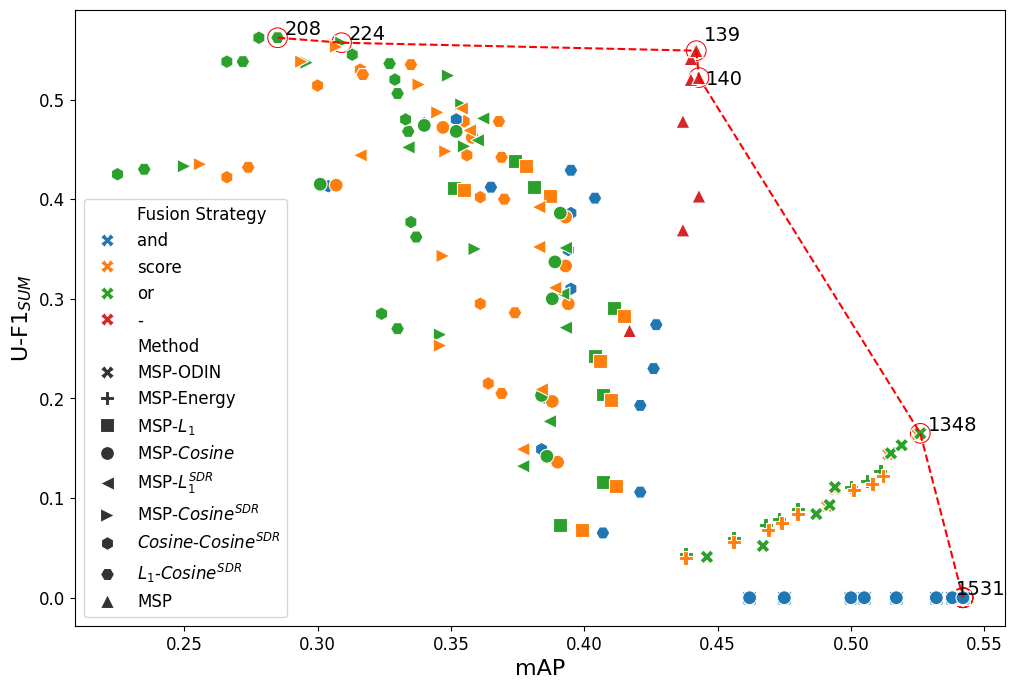

In [33]:
# Constants for the style of the plots
#HUE_ORDER = ['-', '$HDBSCAN$', '$KMeans^{10}$-$HDBSCAN$']
STYLE_ORDER = ['MSP-ODIN', 'MSP-Energy', 'MSP-$L_1$', 'MSP-$Cosine$', 'MSP-$L^{SDR}_1$', 'MSP-$Cosine^{SDR}$', '$Cosine$-$Cosine^{SDR}$', '$L_1$-$Cosine^{SDR}$', 'MSP'] #, 'MSP']
OTHER_MARKERS = {
    'MSP-ODIN': 'X', # o
    'MSP-Energy': 'P',  #s
    'MSP-$L_1$': 's',
    'MSP-$Cosine$': 'o',
    'MSP-$L^{SDR}_1$': '<',#'^',#'d',
    'MSP-$Cosine^{SDR}$': '>',#'v',#'*',
    '$Cosine$-$Cosine^{SDR}$': 'h',
    '$L_1$-$Cosine^{SDR}$': 'H',
    'MSP': '^',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = False

# Constants
XLIM = (0.26, 0.515)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.205)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.1, 0.7)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)


# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], 'red',palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',  style='Method',
                #hue='Cluster Method', 
                hue='Fusion Strategy',
                s=MARKER_SIZE, #hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                #palette=colors_for_methods,
                ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ3_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_fusion_methods_with_MSP.pdf', bbox_inches='tight')
plt.show()

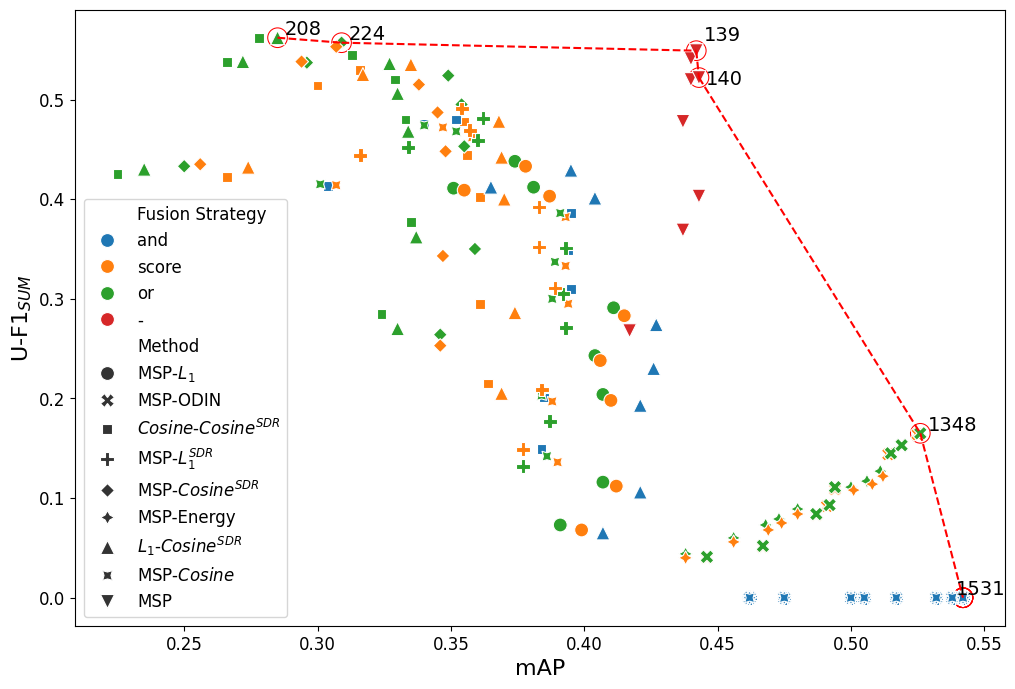

In [34]:
# Constants for the style of the plots
# HUE_ORDER = ['-', '$HDBSCAN$', '$KMeans^{10}$-$HDBSCAN$']
# STYLE_ORDER = ['MSP-Energy', 'MSP-Cosine', 'MSP-Cosine$^{SDR}$', 'Cosine-Cosine$^{SDR}$'] #, 'MSP']
# OTHER_MARKERS = {
#     'MSP-Energy': 's',
#     'MSP-Cosine': 'D',
#     'MSP-Cosine$^{SDR}$': 'o',
#     'Cosine-Cosine$^{SDR}$': 'X',
#     'MSP': '*',
# }

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = False

# Constants
XLIM = (0.26, 0.515)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.205)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.1, 0.7)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',  style='Method',
                #hue='Method', 
                hue='Fusion Strategy',
                s=MARKER_SIZE,# hue_order=HUE_ORDER, 
                # style_order=STYLE_ORDER,
                # markers=OTHER_MARKERS,
                #palette=colors_for_methods,
                ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ3_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_fusion_methods_with_MSP.pdf', bbox_inches='tight')
plt.show()

In [35]:
df_final.iloc[non_dominated_points]

,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,Fusion Strategy,U-F1_(SUM)
77,$L_1$-$Cosine^{SDR}$,one-HDBSCAN,0.010,0.435,0.287,0.383,0.404,0.365,0.285,0.054,0.179,0.159,0.203,208,0.106,or,0.562
61,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.010,0.460,0.284,0.375,0.404,0.349,0.309,0.043,0.182,0.169,0.198,224,0.105,or,0.557
197,MSP,-,0.010,0.723,0.276,0.370,0.378,0.363,0.442,0.078,0.179,0.155,0.212,139,0.087,-,0.549
198,MSP,-,0.005,0.725,0.276,0.354,0.319,0.397,0.443,0.078,0.168,0.127,0.247,140,0.088,-,0.522
191,MSP-ODIN,-,0.001,0.782,0.084,0.084,0.182,0.054,0.526,0.045,0.081,0.122,0.061,1348,0.128,or,0.165
7,MSP-$L_1$,$One$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
15,MSP-ODIN,-,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
31,MSP-$L^{SDR}_1$,$One$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
39,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
55,MSP-Energy,-,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000


Then compare non-dominated solutions of fusion methods against non-dominated solutions of distance methods and post-hoc methods

#### Non-dominated solutions of fusion methods against non-dominated solutions of distance methods and post-hoc methods

In [36]:
def assign_type_to_fusion(df: pd.DataFrame) -> pd.DataFrame:
    # Assign the type to the fusion methods depending on the type of fusion
    # Two logits: non-dominated fusion logits
    # Logit-distance: non-dominated fusion logits-distance
    # Two distance: non-dominated fusion distance

    # Create a new column with the type
    df['Type'] = 'Non-dominated fusion'

    # Go over the rows and assign the type based on WHICH_FUSION_METHOD
    for i, row in df.iterrows():
        row_method = row['Method']
        row_fusion_type = WHICH_FUSION_TYPE[row_method]
        df.at[i, 'Type'] = f'Non-dominated fusion {row_fusion_type}'
    
    return df


In [37]:
df_non_dominated_fusion_methods

,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,Fusion Strategy,U-F1_(SUM)
7,MSP-$L_1$,$One$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
15,MSP-ODIN,-,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
31,MSP-$L^{SDR}_1$,$One$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
39,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
55,MSP-Energy,-,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,and,0.000
59,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.100,0.513,0.234,0.343,0.624,0.237,0.354,0.048,0.152,0.253,0.108,162,0.086,or,0.495
60,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.050,0.500,0.235,0.359,0.558,0.265,0.349,0.046,0.165,0.225,0.130,181,0.100,or,0.524
61,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.010,0.460,0.284,0.375,0.404,0.349,0.309,0.043,0.182,0.169,0.198,224,0.105,or,0.557
68,MSP-$L_1$,$One$,0.050,0.635,0.149,0.198,0.569,0.120,0.411,0.018,0.093,0.177,0.063,382,0.172,or,0.291
70,MSP-$L_1$,$One$,0.005,0.588,0.201,0.291,0.367,0.240,0.374,0.035,0.147,0.140,0.154,557,0.155,or,0.438


In [38]:
# Collect the non-dominated points of the cluster methods and post hoc
# Name cluster methods as them as f"Non-dominated distance"" and add them to the df
# Name the post hoc methods as Non-dominated post-hoc and add them to the df

# Cluster methods
# Vanilla
df_non_dominated_all_cluster_methods_new_names = df_non_dominated_cluster_methods.copy()
df_non_dominated_all_cluster_methods_new_names.rename(columns={'Distance Metric': 'Method'}, inplace=True)
df_non_dominated_all_cluster_methods_new_names['Type'] = 'Non-dominated FMap'
df_non_dominated_all_cluster_methods_new_names['Fusion Strategy'] = '-'
#df_non_dominated_cluster_methods_new_names['Method'] = 'FMap'
# SDR
df_non_dominated_cluster_methods_SDR_new_names = df_non_dominated_cluster_methods_SDR.copy()
df_non_dominated_cluster_methods_SDR_new_names.rename(columns={'Distance Metric': 'Method'}, inplace=True)
df_non_dominated_cluster_methods_SDR_new_names['Type'] = 'Non-dominated FMap'
df_non_dominated_cluster_methods_SDR_new_names['Fusion Strategy'] = '-'
#df_non_dominated_cluster_methods_SDR_new_names['Method'] = 'Non-dominated distance'
# EUL
df_non_dominated_cluster_methods_EUL_new_names = df_non_dominated_cluster_methods_EUL.copy()
df_non_dominated_cluster_methods_EUL_new_names.rename(columns={'Distance Metric': 'Method'}, inplace=True)
df_non_dominated_cluster_methods_EUL_new_names['Type'] = 'Non-dominated FMap'
df_non_dominated_cluster_methods_EUL_new_names['Fusion Strategy'] = '-'
#df_non_dominated_cluster_methods_EUL_new_names['Method'] = 'Non-dominated distance'

# Post-hoc
df_non_dominated_logits_new_names = df_non_dominated_logits.copy()
df_non_dominated_logits_new_names['Type'] = 'Non-dominated logit (MSP)'
df_non_dominated_logits_new_names['Fusion Strategy'] = '-'
#df_non_dominated_logits_new_names['Distance Metric'] = '-'

# Fusion
df_non_dominated_fusion_methods_new_names = df_non_dominated_fusion_methods.copy()
df_non_dominated_fusion_methods_new_names.rename(columns={'conf_thr_test': 'Confidence Threshold'}, inplace=True)
df_non_dominated_fusion_methods_new_names = assign_type_to_fusion(df_non_dominated_fusion_methods_new_names)
#df_non_dominated_fusion_methods_new_names['Type'] = 'Non-dominated fusion'
#df_non_dominated_fusion_methods_new_names['Cluster Method'] = 'Non-dominated fusion'

# Concatenate the dataframes
df_non_dominated_distance_vs_posthoc_vs_fusion = pd.concat([
    df_non_dominated_all_cluster_methods_new_names,
    df_non_dominated_cluster_methods_SDR_new_names,
    df_non_dominated_cluster_methods_EUL_new_names,
    df_non_dominated_logits_new_names,
    df_non_dominated_fusion_methods_new_names
]).reset_index(drop=True)

# Save the dataframe to a CSV file
df_non_dominated_distance_vs_posthoc_vs_fusion.to_csv(Path(f"results/{WHICH_YOLO_VERSION}") / "df_non_dominated_distance_vs_posthoc_vs_fusion.csv", index=False)

# Rename the Distance to Method
#df_non_dominated_distance_vs_posthoc_vs_fusion = df_non_dominated_distance_vs_posthoc_vs_fusion.rename(columns={'Distance': 'Method'})

df_final = df_non_dominated_distance_vs_posthoc_vs_fusion.copy()
print(df_final['Method'].unique())
print(df_final['Type'].unique())
df_final.tail()

['$Cosine$' '$L_1$' '$L_2$' '$Cosine^{SDR}$' '$L^{SDR}_1$'
 '$Cosine^{EUL}$' '$L^{EUL}_1$' '$L^{EUL}_2$' 'MSP' 'MSP-$L_1$' 'MSP-ODIN'
 'MSP-$L^{SDR}_1$' 'MSP-$Cosine^{SDR}$' 'MSP-Energy'
 '$L_1$-$Cosine^{SDR}$' '$Cosine$-$Cosine^{SDR}$' 'MSP-$Cosine$']
['Non-dominated FMap' 'Non-dominated logit (MSP)'
 'Non-dominated fusion logit-FMap' 'Non-dominated fusion logit-logit'
 "Non-dominated fusion FMap-FMap'"]


,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type,Fusion Strategy
60,$L_1$-$Cosine^{SDR}$,one-HDBSCAN,0.050,0.654,0.148,0.185,0.572,0.110,0.427,0.019,0.089,0.202,0.057,397,0.163,0.274,Non-dominated fusion FMap-FMap',and
61,$L_1$-$Cosine^{SDR}$,one-HDBSCAN,0.010,0.628,0.153,0.263,0.431,0.189,0.404,0.037,0.138,0.175,0.113,521,0.157,0.401,Non-dominated fusion FMap-FMap',and
62,$L_1$-$Cosine^{SDR}$,one-HDBSCAN,0.005,0.612,0.198,0.280,0.369,0.226,0.395,0.039,0.149,0.154,0.145,587,0.149,0.429,Non-dominated fusion FMap-FMap',and
63,MSP-$Cosine$,$HDBSCAN$,0.001,0.810,0.000,0.000,0.000,0.000,0.542,0.000,0.000,0.000,0.000,1531,0.135,0.000,Non-dominated fusion logit-FMap,and
64,MSP-ODIN,-,0.001,0.782,0.084,0.084,0.182,0.054,0.526,0.045,0.081,0.122,0.061,1348,0.128,0.165,Non-dominated fusion logit-logit,or


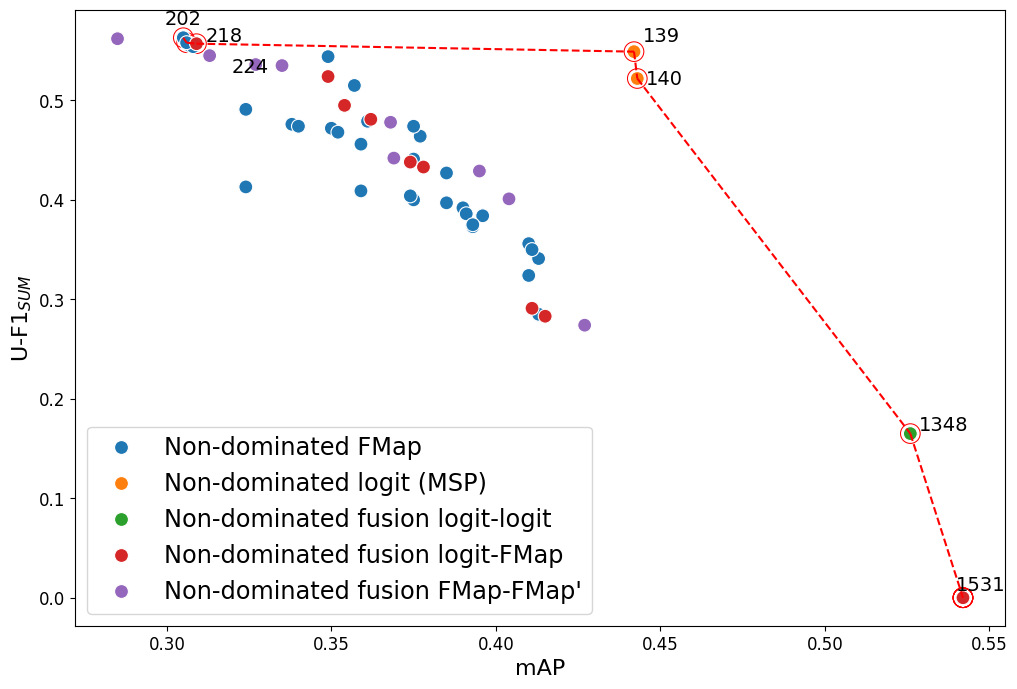

In [39]:
# Constants for the style of the plots
#STYLE_ORDER = ['Non-dominated distance', 'Non-dominated post-hoc', 'Non-dominated fusion']
#HUE_ORDER = ['Non-dominated feature', 'Non-dominated logit (MSP)', 'Non-dominated fusion logit-logit', 'Non-dominated fusion logit-feature', 'Non-dominated fusion feature-feature']
# OTHER_MARKERS = {
#     'Non-dominated vanilla': '*',
#     'Non-dominated SDR': 'X',
#     'Non-dominated fusion': 'P',
# }
HUE_ORDER = ['Non-dominated FMap', 'Non-dominated logit (MSP)', 'Non-dominated fusion logit-logit', 'Non-dominated fusion logit-FMap', "Non-dominated fusion FMap-FMap'"]

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = False

# Constants
XLIM = (0.31, 0.52)
YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_after_rq1_rq2_rq3 = df_final.iloc[non_dominated_points].reset_index(drop=True)

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #style='Distance',
                hue='Type', hue_order=HUE_ORDER, 
                s=MARKER_SIZE, 
                #style_order=STYLE_ORDER,
                #markers=OTHER_MARKERS,
                #palette=colors_for_methods,
                ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ3_FIGURES_FOLDER / f'{WHICH_YOLO_VERSION}_{WHICH_SUBSET}_distance_vs_posthoc_vs_fusion_non-dominated_comparison.pdf', bbox_inches='tight')
plt.show()

## RQ5. Comparison between YOLO versions

In [40]:
def assign_type_to_fusion(df: pd.DataFrame) -> pd.DataFrame:
    # Assign the type to the fusion methods depending on the type of fusion
    # Two logits: non-dominated fusion logits
    # Logit-distance: non-dominated fusion logits-distance
    # Two distance: non-dominated fusion distance

    # Create a new column with the type
    df['Type'] = 'Non-dominated fusion'

    # Go over the rows and assign the type based on WHICH_FUSION_METHOD
    for i, row in df.iterrows():
        row_method = row['Method']
        row_fusion_type = WHICH_FUSION_TYPE[row_method]
        df.at[i, 'Type'] = f'Non-dominated fusion {row_fusion_type}'
    
    return df

In [41]:
yolo_versions_paths = {
    "V9":  Path(f"results/V9"),
    # "V10": Path(f"results/V10"),
    "V11": Path(f"results/V11"),
    "V12": Path(f"results/V12_epoch275"),
}

In [42]:
yolo_versions_dfs = {}
for yolo_version, path in yolo_versions_paths.items():
    # folders_to_consider = [path]
    # df = convert_list_of_paths_into_df(folders_to_consider)
    # df.reset_index(drop=True, inplace=True)
    # df_fusion_methods = format_df(df, columns_to_keep=FINAL_COLUMNS_FUSION)
    # df_fusion_methods.reset_index(drop=True, inplace=True)
    # df_final = df_fusion_methods.copy()

    # # Change the column name cluster_method to Cluster Method and Method to Distance
    # df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
    # df_final = df_final.rename(columns={'fusion_strat': 'Fusion Strategy'})
    # df_final = df_final.rename(columns={'conf_thr_test': 'Confidence Threshold'})

    # # Obtain the logits non-dominated points
    # non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
    # # Extract the non-dominated points into a df
    # df_non_dominated_fusion_methods = df_final.iloc[non_dominated_points]

    # print(df_final['Method'].unique())
    # print(df_final['Cluster Method'].unique())
    
    # Load Df
    df_non_dominated_distance_vs_posthoc_vs_fusion = pd.read_csv(path / "df_non_dominated_distance_vs_posthoc_vs_fusion.csv")

    yolo_versions_dfs[yolo_version] = df_non_dominated_distance_vs_posthoc_vs_fusion

Creando gráfico para el subset: SUM con YOLOv9
Creando gráfico para el subset: SUM con YOLOv10
Creando gráfico para el subset: SUM con YOLOv11
Creando gráfico para el subset: SUM con YOLOv12


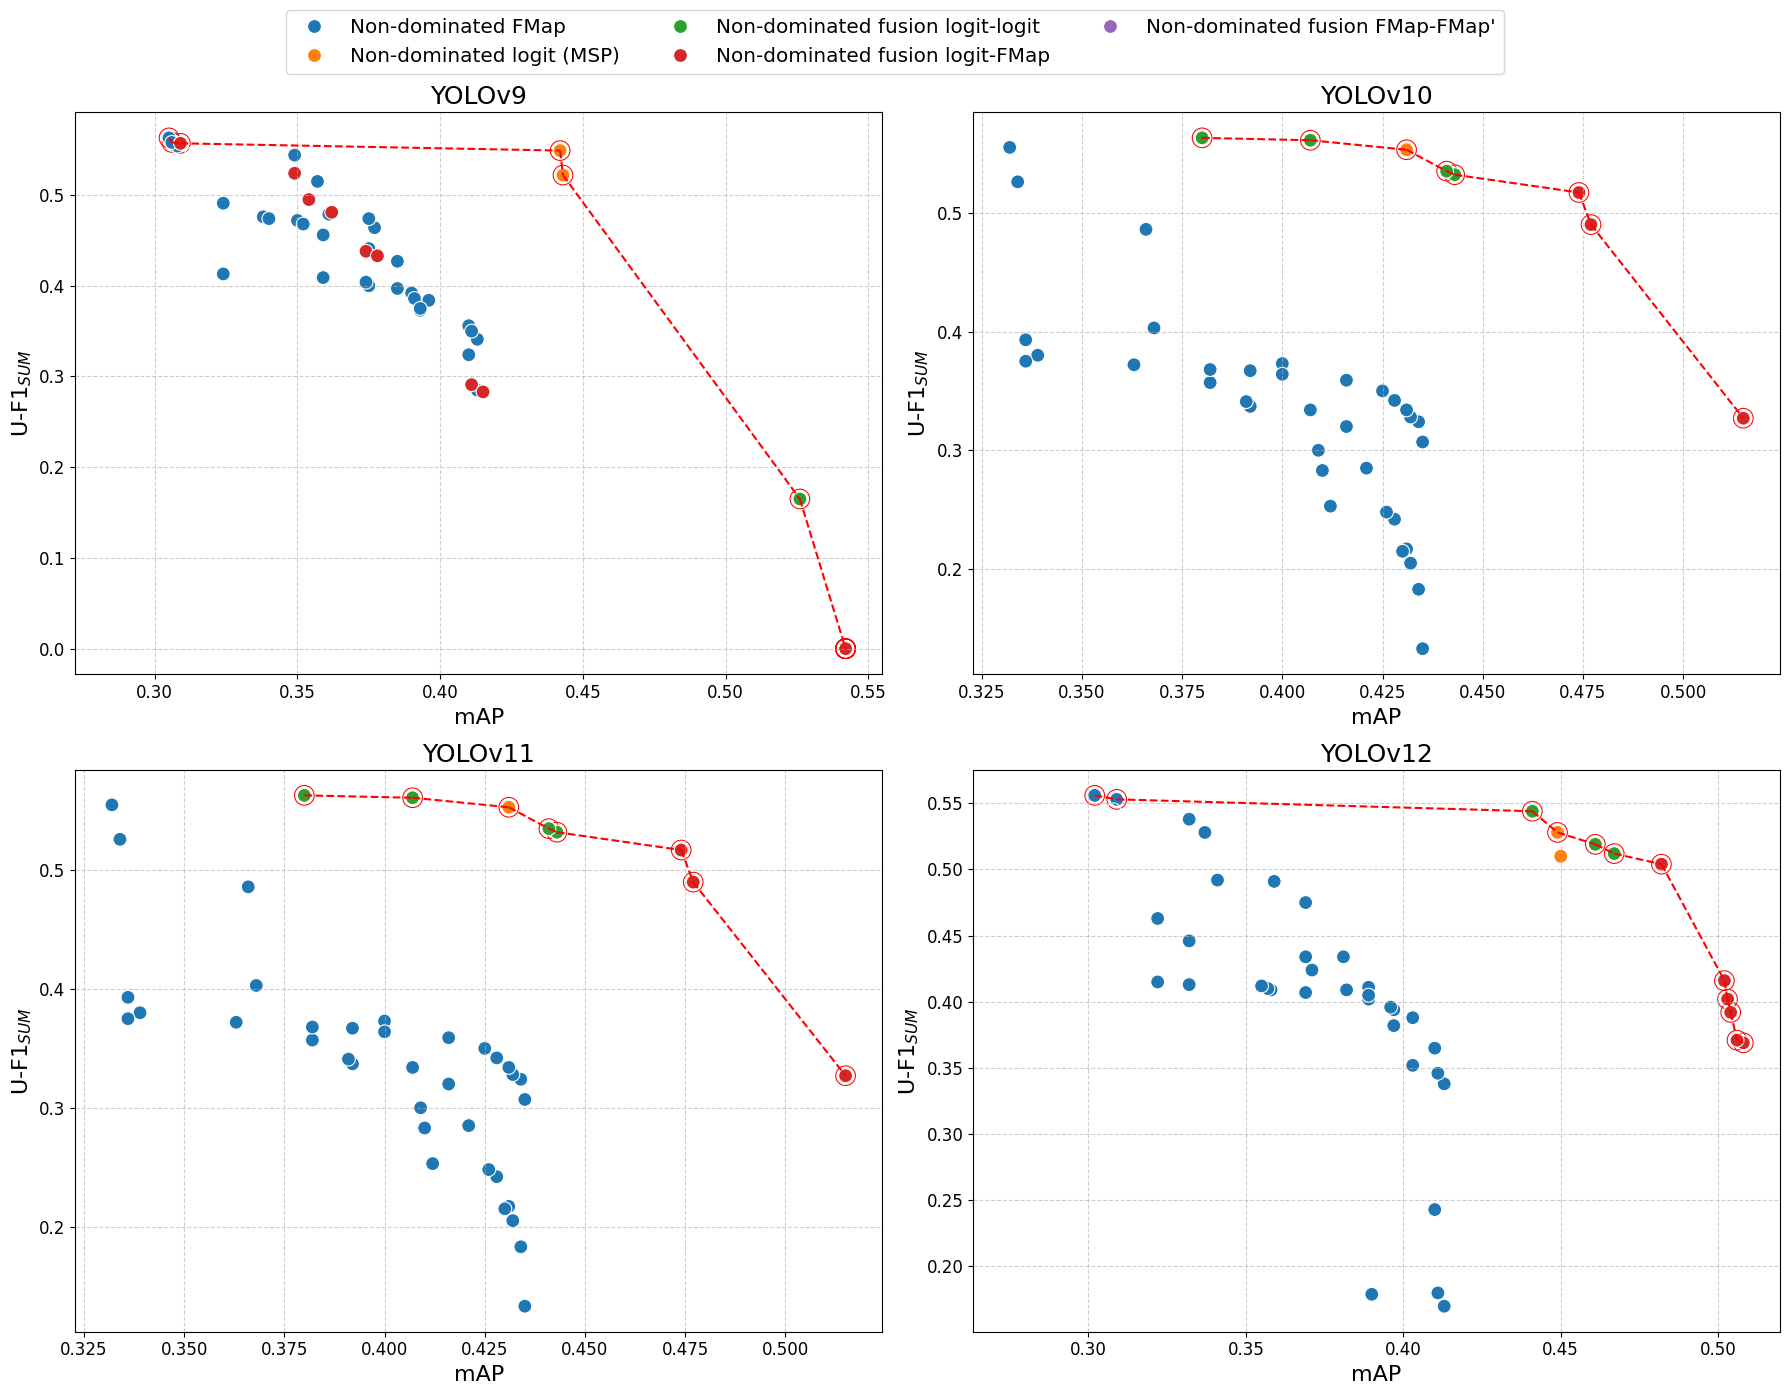

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONSTANTES Y CONFIGURACIÓN (sin cambios) ---
HUE_ORDER = ['Non-dominated FMap', 'Non-dominated logit (MSP)', 'Non-dominated fusion logit-logit', 'Non-dominated fusion logit-FMap', "Non-dominated fusion FMap-FMap"]

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = False
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True # No es necesario, la leyenda se maneja de forma global
USE_LIMS = False

# Constants
XLIM = (0.31, 0.52)
YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'x-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# # --- FUNCIONES AUXILIARES (Usa tus propias definiciones) ---
# # Necesitas tener estas funciones definidas en tu código.
# # Para que este ejemplo sea ejecutable, creo versiones dummy.
# def obtain_non_dominated_points_positions_map_f1(df, subset):
#     # Esta es una implementación de ejemplo, usa la tuya.
#     non_dominated_indices = []
#     for i, row in df.iterrows():
#         is_dominated = False
#         for j, other_row in df.iterrows():
#             if i == j:
#                 continue
#             if other_row['mAP'] >= row['mAP'] and other_row[f'U-F1_({subset})'] >= row[f'U-F1_({subset})']:
#                 if other_row['mAP'] > row['mAP'] or other_row[f'U-F1_({subset})'] > row[f'U-F1_({subset})']:
#                     is_dominated = True
#                     break
#         if not is_dominated:
#             non_dominated_indices.append(i)
#     return non_dominated_indices

# def highlight_non_dominated_points(ax, df, positions, x_col, y_col, size, color, linewidth):
#     df_nd = df.iloc[positions]
#     ax.scatter(df_nd[x_col], df_nd[y_col], s=size, facecolors='none', edgecolors=color, linewidth=linewidth)

# def add_line_connecting_non_dominated_points(ax, df, positions, x_col, y_col, color, linestyle, linewidth):
#     df_nd = df.iloc[positions].sort_values(by=x_col)
#     ax.plot(df_nd[x_col], df_nd[y_col], color=color, linestyle=linestyle, linewidth=linewidth)

# def add_text_to_non_dominated_points(ax, df, positions, x_col, y_col, text_col, fontsize):
#     df_nd = df.iloc[positions]
#     for i, point in df_nd.iterrows():
#         ax.text(point[x_col]*1.01, point[y_col]*1.01, f"{point[text_col]}", fontsize=fontsize)

# --- DATOS DE EJEMPLO (Reemplaza esto con tus 4 dataframes) ---
def crear_dataframe_ejemplo():
    """Crea un dataframe con datos aleatorios para la demostración."""
    data = {
        'mAP': np.random.rand(20) * 0.2 + 0.3,
        f'U-F1_({WHICH_SUBSET})': np.random.rand(20) * 0.3 + 0.3,
        'Type': np.random.choice(HUE_ORDER, 20),
        'A-OSE': np.random.rand(20) * 10
    }
    return pd.DataFrame(data)

df1 = yolo_versions_dfs['V9'].copy()
df2 = yolo_versions_dfs['V11'].copy()
df3 = yolo_versions_dfs['V11'].copy()
df4 = yolo_versions_dfs['V12'].copy()

# Lista de dataframes y títulos para iterar sobre ellos
lista_de_dataframes = [df1, df2, df3, df4]
#titulos_de_graficos = ['YOLOv8n', 'YOLOv8s', 'YOLOv8m', 'YOLOv8l'] # Títulos de ejemplo
titulos_de_graficos = ["YOLOv9", "YOLOv10", "YOLOv11", "YOLOv12"]

# --- FUNCIÓN DE DIBUJADO REFACTORIZADA ---
def crear_grafico_individual(ax, df, subset_name, titulo):
    """
    Dibuja un único gráfico de dispersión en el eje (ax) proporcionado.
    """
    print(f"Creando gráfico para el subset: {subset_name} con {titulo}")
    # Buscar puntos no dominados
    non_dominated_points = obtain_non_dominated_points_positions_map_f1(df, subset_name)

    # Gráfico de dispersión principal
    sns.scatterplot(
        data=df, x='mAP', y=f'U-F1_({subset_name})',
        hue='Type', hue_order=HUE_ORDER,
        s=MARKER_SIZE,
        ax=ax,
        legend=False  # Desactivamos la leyenda para los plots individuales
    )

    # Funcionalidades adicionales
    if USE_LIMS:
        ax.set_xlim(XLIM)
        ax.set_ylim(YLIM)

    if HIGHLIGHT_NON_DOMINATED_POINTS:
        highlight_non_dominated_points(ax, df, non_dominated_points, 'mAP', f'U-F1_({subset_name})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

    if CONNECT_NON_DOMINATED_POINTS:
        add_line_connecting_non_dominated_points(ax, df, non_dominated_points, 'mAP', f'U-F1_({subset_name})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

    if ADD_AOSE_VALUES:
        add_text_to_non_dominated_points(ax, df, non_dominated_points, 'mAP', f'U-F1_({subset_name})', 'A-OSE', FONTSIZE_AOSE)

    # Configuración de etiquetas y título del subplot
    ax.set_xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
    ax.set_ylabel(f'U-F1$_{{{subset_name}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICKS)
    ax.set_title(titulo, fontsize=FONTSIZE_XY_LABELS + 2)
    ax.grid(True, linestyle='--', alpha=0.6)

# --- CREACIÓN DE LA FIGURA Y LOS SUBPLOTS ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Iterar sobre los dataframes y los ejes para dibujar cada gráfico
# usamos .flatten() para convertir la matriz de ejes 2x2 en una lista simple
for ax, df, titulo in zip(axes.flatten(), lista_de_dataframes, titulos_de_graficos):
    crear_grafico_individual(ax, df, WHICH_SUBSET, titulo)

# --- CREACIÓN DE LA LEYENDA COMPARTIDA ---
# Obtener manejadores (puntos de color) y etiquetas de la leyenda del último gráfico dibujado
handles, labels = ax.get_legend_handles_labels()

# Crear una única leyenda para toda la figura en la parte superior
# ncol=len(HUE_ORDER) hace que la leyenda sea horizontal
fig.legend(
    unique_handles,
    unique_labels,
    loc='upper center',          # Posición en el centro y arriba
    bbox_to_anchor=(0.5, 1.0),   # Anclarla ligeramente por encima del área de los plots
    ncol=3,         # Número de columnas igual al número de elementos
    fontsize=FONTSIZE_LEGEND
)

# --- AJUSTES FINALES Y GUARDADO ---
# Ajusta el layout para que los gráficos no se solapen y deja espacio para la leyenda superior
# rect=[left, bottom, right, top]
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Guardar y mostrar la figura
# plt.savefig(f'figura_combinada_{WHICH_YOLO_VERSION}_{WHICH_SUBSET}.pdf', bbox_inches='tight')
plt.show()

In [44]:
len(HUE_ORDER)

5

## RQ4. Comparison against SOTA

### Configure the dataframes

In [6]:
df_sota = pd.read_csv('results/SOTA/sota_methods.csv', delimiter=';')
# In all the dataframe, change the "," for the "."
df_sota = df_sota.apply(lambda x: x.str.replace(',', '.'))
# Make all the columns be of the format :.3f if they have a float
df_sota = df_sota.applymap(lambda x: f'{float(x):.3f}' if x.replace('.', '', 1).isdigit() else x)
# Remove decimals from COCO-Mix AOSE column
df_sota['COCO-Mix AOSE'] = df_sota['COCO-Mix AOSE'].apply(lambda x: f'{float(x):.0f}' if x.replace('.', '', 1).isdigit() else x)
# Add leading zeros to the COCO-Mix AOSE if the number is less than 3 digits
df_sota['COCO-Mix AOSE'] = df_sota['COCO-Mix AOSE'].apply(lambda x: f'{int(x):03d}' if x.isdigit() else x)
# Move the row with OW-DETR method to the last row. First check which row is the one with the OW-DETR method
idx_owdetr = df_sota[df_sota['Methods'] == 'OW-DETR'].index[0]
# Add the row with the OW-DETR method to the last row using pd.concat
df_sota = pd.concat([df_sota, df_sota.iloc[[idx_owdetr]]]).reset_index(drop=True)
# Remove the row idx_owdetr from the df_sota
df_sota = df_sota.drop(idx_owdetr)
# Reset the index
df_sota.reset_index(drop=True, inplace=True)
# Change the model of the OW-DETR to DETR
df_sota['Model'].iloc[-1] = 'DETR'
df_sota


/tmp/ipykernel_239904/3040079146.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sota = df_sota.applymap(lambda x: f'{float(x):.3f}' if x.replace('.', '', 1).isdigit() else x)


,Methods,Model,VOC-Test mAP,COCO-OOD U-AP,COCO-OOD U-F1,COCO-OOD U-PRE,COCO-OOD U-REC,COCO-Mix mAP,COCO-Mix U-AP,COCO-Mix U-F1,COCO-Mix U-PRE,COCO-Mix U-REC,COCO-Mix AOSE,COCO-Mix WI
0,-,Faster-RCNN,0.483,-,-,-,-,-,-,-,-,-,-,-
1,MSP,Faster-RCNN,0.470,0.213,0.314,0.279,0.359,0.364,0.055,0.169,0.190,0.153,588,0.135
2,Mahalanobis,Faster-RCNN,0.447,0.129,0.271,0.309,0.241,0.351,0.051,0.149,0.207,0.116,604,0.165
3,Energy score,Faster-RCNN,0.474,0.213,0.308,0.260,0.377,0.364,0.048,0.169,0.167,0.171,470,0.137
4,ORE,Faster-RCNN,0.243,0.214,0.255,0.153,0.782,0.213,0.140,0.175,0.103,0.592,485,0.089
5,VOS^1,Faster-RCNN,0.485,0.135,0.196,0.342,0.137,0.377,0.040,0.101,0.262,0.062,640,0.152
6,VOS^2,Faster-RCNN,0.469,0.205,0.317,0.291,0.348,0.364,0.051,0.172,0.184,0.163,409,0.124
7,UnSniffer,Faster-RCNN,0.464,0.454,0.479,0.433,0.535,0.359,0.150,0.287,0.222,0.409,398,0.175
8,OW-DETR,DETR,0.420,0.033,0.056,0.030,0.380,0.414,0.007,0.025,0.014,0.161,569,0.086


In [7]:
# Rename columns to match the ones in our dataframes
COLUMN_NAMES_FROM_SOTA_TO_OURS = {
    'Methods': 'Method',
    'VOC-Test mAP': 'mAP_(VOC_test)',
    'COCO-OOD U-AP': 'U-AP_(COOD)',
    'COCO-OOD U-F1': 'U-F1_(COOD)',
    'COCO-OOD U-PRE': 'U-PRE_(COOD)',
    'COCO-OOD U-REC': 'U-REC_(COOD)',
    'COCO-Mix mAP': 'mAP',
    'COCO-Mix U-AP': 'U-AP_(CMIX)',
    'COCO-Mix U-F1': 'U-F1_(CMIX)',
    'COCO-Mix U-PRE': 'U-PRE_(CMIX)',
    'COCO-Mix U-REC': 'U-REC_(CMIX)',
    'COCO-Mix AOSE': 'A-OSE',
    'COCO-Mix WI': 'WI-08',
}
df_sota = df_sota.rename(columns=COLUMN_NAMES_FROM_SOTA_TO_OURS)
df_sota

,Method,Model,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
0,-,Faster-RCNN,0.483,-,-,-,-,-,-,-,-,-,-,-
1,MSP,Faster-RCNN,0.470,0.213,0.314,0.279,0.359,0.364,0.055,0.169,0.190,0.153,588,0.135
2,Mahalanobis,Faster-RCNN,0.447,0.129,0.271,0.309,0.241,0.351,0.051,0.149,0.207,0.116,604,0.165
3,Energy score,Faster-RCNN,0.474,0.213,0.308,0.260,0.377,0.364,0.048,0.169,0.167,0.171,470,0.137
4,ORE,Faster-RCNN,0.243,0.214,0.255,0.153,0.782,0.213,0.140,0.175,0.103,0.592,485,0.089
5,VOS^1,Faster-RCNN,0.485,0.135,0.196,0.342,0.137,0.377,0.040,0.101,0.262,0.062,640,0.152
6,VOS^2,Faster-RCNN,0.469,0.205,0.317,0.291,0.348,0.364,0.051,0.172,0.184,0.163,409,0.124
7,UnSniffer,Faster-RCNN,0.464,0.454,0.479,0.433,0.535,0.359,0.150,0.287,0.222,0.409,398,0.175
8,OW-DETR,DETR,0.420,0.033,0.056,0.030,0.380,0.414,0.007,0.025,0.014,0.161,569,0.086


In [8]:
# Hand pick some of them
df_selected_post_hoc_and_fusion_methods = df_non_dominated_after_rq1_rq2_rq3.iloc[[0, 3, 8, 9]]
df_selected_post_hoc_and_fusion_methods

NameError: name 'df_non_dominated_after_rq1_rq2_rq3' is not defined

In [41]:
df_selected_fmap_methods = df_non_dominated_all_cluster_methods.iloc[[7, 15, 16, 27]]
df_selected_fmap_methods["Fusion Strategy"] = "-"
df_selected_fmap_methods.rename(columns={'Distance Metric': 'Method'}, inplace=True)
df_selected_fmap_methods

/tmp/ipykernel_100579/1914360095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_fmap_methods["Fusion Strategy"] = "-"
/tmp/ipykernel_100579/1914360095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_fmap_methods.rename(columns={'Distance Metric': 'Method'}, inplace=True)


,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type,Fusion Strategy
7,$Cosine$,$HDBSCAN$,0.10,0.620,0.160,0.243,0.655,0.149,0.420,0.025,0.132,0.272,0.087,239,0.120,0.375,Non-dominated vanilla,-
15,$Cosine^{SDR}$,$KMeans^{10}$,0.01,0.471,0.296,0.392,0.427,0.363,0.323,0.061,0.190,0.174,0.209,185,0.082,0.582,Non-dominated SDR,-
16,$Cosine^{SDR}$,$One$,0.10,0.527,0.238,0.351,0.668,0.238,0.380,0.051,0.164,0.275,0.116,155,0.087,0.515,Non-dominated SDR,-
27,$L^{EUL}_1$,$One$,0.05,0.662,0.161,0.254,0.239,0.270,0.435,0.031,0.119,0.099,0.150,368,0.141,0.373,Non-dominated EUL,-


In [42]:
df_selected_rq1_rq2_rq3 = pd.concat([df_selected_fmap_methods, df_selected_post_hoc_and_fusion_methods]).reset_index(drop=True)
df_selected_rq1_rq2_rq3["Model"] = "YOLOv8"
# Convert all numeric columns to string with 3 decimals except for A-OSE, which is an integer, so dont convert it
columns_to_convert = [col for col in df_selected_rq1_rq2_rq3.columns if col not in ['Method', 'Cluster Method', 'Confidence Threshold', 'A-OSE', 'Model', 'Type', 'Fusion Strategy']]
print(columns_to_convert)
df_selected_rq1_rq2_rq3[columns_to_convert] = df_selected_rq1_rq2_rq3[columns_to_convert].map(lambda x: f'{float(x):.3f}')
df_selected_rq1_rq2_rq3['A-OSE'] = df_selected_rq1_rq2_rq3['A-OSE'].apply(lambda x: f'{int(x):03d}')
df_selected_rq1_rq2_rq3

['mAP_(VOC_test)', 'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'WI-08', 'U-F1_(SUM)']


,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type,Fusion Strategy,Model
0,$Cosine$,$HDBSCAN$,0.10,0.620,0.160,0.243,0.655,0.149,0.420,0.025,0.132,0.272,0.087,239,0.120,0.375,Non-dominated vanilla,-,YOLOv8
1,$Cosine^{SDR}$,$KMeans^{10}$,0.01,0.471,0.296,0.392,0.427,0.363,0.323,0.061,0.190,0.174,0.209,185,0.082,0.582,Non-dominated SDR,-,YOLOv8
2,$Cosine^{SDR}$,$One$,0.10,0.527,0.238,0.351,0.668,0.238,0.380,0.051,0.164,0.275,0.116,155,0.087,0.515,Non-dominated SDR,-,YOLOv8
3,$L^{EUL}_1$,$One$,0.05,0.662,0.161,0.254,0.239,0.270,0.435,0.031,0.119,0.099,0.150,368,0.141,0.373,Non-dominated EUL,-,YOLOv8
4,MSP,-,0.05,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576,Non-dominated logit (MSP),-,YOLOv8
5,MSP-$Cosine$,$HDBSCAN$,0.05,0.567,0.289,0.397,0.563,0.307,0.371,0.048,0.193,0.222,0.171,079,0.057,0.590,Non-dominated fusion logit-FMap,or,YOLOv8
6,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.01,0.765,0.275,0.362,0.417,0.320,0.493,0.107,0.188,0.197,0.179,262,0.092,0.550,Non-dominated fusion logit-FMap,and,YOLOv8
7,MSP-ODIN,-,0.01,0.727,0.271,0.376,0.397,0.357,0.450,0.115,0.181,0.159,0.211,144,0.079,0.557,Non-dominated fusion logit-logit,score,YOLOv8


In [43]:
# Create a dataframe with the info of YOLOv8 in VOC-Test.
# First copy the line of df_sota with info about Faster RCNN
df_yolov8 = df_sota.iloc[0:1].copy()
df_yolov8["Model"] = "YOLOv8"
df_yolov8["mAP_(VOC_test)"] = "0.750"
df_yolov8


,Method,Model,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
0,-,YOLOv8,0.750,-,-,-,-,-,-,-,-,-,-,-


In [44]:
# Fuse all the data into one dataframe
df_final_SOTA = pd.concat([df_sota, df_yolov8, df_selected_rq1_rq2_rq3]).reset_index(drop=True)
df_final_SOTA

,Method,Model,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,Cluster Method,Confidence Threshold,U-F1_(SUM),Type,Fusion Strategy
0,-,Faster-RCNN,0.483,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN
1,MSP,Faster-RCNN,0.470,0.213,0.314,0.279,0.359,0.364,0.055,0.169,0.190,0.153,588,0.135,NaN,NaN,NaN,NaN,NaN
2,Mahalanobis,Faster-RCNN,0.447,0.129,0.271,0.309,0.241,0.351,0.051,0.149,0.207,0.116,604,0.165,NaN,NaN,NaN,NaN,NaN
3,Energy score,Faster-RCNN,0.474,0.213,0.308,0.260,0.377,0.364,0.048,0.169,0.167,0.171,470,0.137,NaN,NaN,NaN,NaN,NaN
4,ORE,Faster-RCNN,0.243,0.214,0.255,0.153,0.782,0.213,0.140,0.175,0.103,0.592,485,0.089,NaN,NaN,NaN,NaN,NaN
5,VOS^1,Faster-RCNN,0.485,0.135,0.196,0.342,0.137,0.377,0.040,0.101,0.262,0.062,640,0.152,NaN,NaN,NaN,NaN,NaN
6,VOS^2,Faster-RCNN,0.469,0.205,0.317,0.291,0.348,0.364,0.051,0.172,0.184,0.163,409,0.124,NaN,NaN,NaN,NaN,NaN
7,UnSniffer,Faster-RCNN,0.464,0.454,0.479,0.433,0.535,0.359,0.150,0.287,0.222,0.409,398,0.175,NaN,NaN,NaN,NaN,NaN
8,OW-DETR,DETR,0.420,0.033,0.056,0.030,0.380,0.414,0.007,0.025,0.014,0.161,569,0.086,NaN,NaN,NaN,NaN,NaN
9,-,YOLOv8,0.750,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN


In [45]:
# Make a table with the non-dominated points. 
# First create the Method column, and put the "FMap" string in it for all the rows
df_table = df_final_SOTA.copy()

# Keep only the columns we want
COLUMNS_TO_KEEP = [
        'Method', 'Model', 'mAP_(VOC_test)', 'U-AP_(COOD)', 'U-F1_(COOD)',
       'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP', 'U-AP_(CMIX)',
       'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'A-OSE', 'WI-08',
    #    'Cluster Method', 'Confidence Threshold', 'mAP', 'U-F1_(SUM)', 'Type',
    #    'Fusion Strategy'
       ]
df_table = df_table[COLUMNS_TO_KEEP]
# Replace VOS^1 for VOS$^1$ and VOS^2 for VOS$^2$
df_table['Method'] = df_table['Method'].apply(lambda x: x.replace('VOS^1', r'VOS$^1$'))
df_table['Method'] = df_table['Method'].apply(lambda x: x.replace('VOS^2', r'VOS$^2$'))
# Replace "Cosine" for \mathit{Cosine}
df_table['Method'] = df_table['Method'].apply(lambda x: x.replace('Cosine', r'\mathit{Cosine}'))
# Replace SDR for \mathit{SDR}
df_table['Method'] = df_table['Method'].apply(lambda x: x.replace('SDR', r'\mathit{SDR}'))
# Rename the column Model to Base Model
df_table = df_table.rename(columns={'Model': 'Base Model'})
df_table

,Method,Base Model,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
0,-,Faster-RCNN,0.483,-,-,-,-,-,-,-,-,-,-,-
1,MSP,Faster-RCNN,0.470,0.213,0.314,0.279,0.359,0.364,0.055,0.169,0.190,0.153,588,0.135
2,Mahalanobis,Faster-RCNN,0.447,0.129,0.271,0.309,0.241,0.351,0.051,0.149,0.207,0.116,604,0.165
3,Energy score,Faster-RCNN,0.474,0.213,0.308,0.260,0.377,0.364,0.048,0.169,0.167,0.171,470,0.137
4,ORE,Faster-RCNN,0.243,0.214,0.255,0.153,0.782,0.213,0.140,0.175,0.103,0.592,485,0.089
5,VOS$^1$,Faster-RCNN,0.485,0.135,0.196,0.342,0.137,0.377,0.040,0.101,0.262,0.062,640,0.152
6,VOS$^2$,Faster-RCNN,0.469,0.205,0.317,0.291,0.348,0.364,0.051,0.172,0.184,0.163,409,0.124
7,UnSniffer,Faster-RCNN,0.464,0.454,0.479,0.433,0.535,0.359,0.150,0.287,0.222,0.409,398,0.175
8,OW-DETR,DETR,0.420,0.033,0.056,0.030,0.380,0.414,0.007,0.025,0.014,0.161,569,0.086
9,-,YOLOv8,0.750,-,-,-,-,-,-,-,-,-,-,-


### Table with the comparison

In [46]:
# Save the table to a latex file and to a latex string
LOCAL_LATEX_PARAMS = LATEX_PARAMS.copy()
# Remove the column Method from header
LOCAL_COLUMNS_FOR_LATEX = [
    'Method',
    'Base Model',
    'mAP',
    'U-AP',
    'U-F1',
    'U-PRE',
    'U-REC',
    'mAP',
    'U-AP',
    'U-F1',
    'U-PRE',
    'U-REC',
    'A-OSE',
    'WI']

latex_str = df_table.to_latex(header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)
df_table.to_latex(RQ4_FIGURES_FOLDER / 'sota.tex', header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)

In [47]:
from collections import OrderedDict

def obtain_best_values_of_columns_rq4(df, columns_to_search_max, columns_to_search_min, column_index_start_value=2):
    # Extract values to dicts of max and min values per
    values_to_underline = OrderedDict()
    #min_values = {}
    for _j, col in enumerate(columns_to_search_max):
        column_values = df[col]
        # Remove the '-' values
        column_values = column_values[column_values != '-']
        # Convert to float
        column_values = column_values.astype(float)
        # Obtain the max value's index
        max_index = column_values.idxmax()
        # Save the name of the column as key and the index as the value
        #max_values[col] = (df['Method'][max_index], column_values.max().round(3))
        #max_values[col] = max_index
        # Save the index of the column as the key and the index of the row as the value
        values_to_underline[int(column_index_start_value + _j)] = max_index

    column_index_start_value += len(columns_to_search_max)

    for _j, col in enumerate(columns_to_search_min):
        column_values = df[col]
        # Remove the '-' values
        column_values = column_values[column_values != '-']
        # Convert to float
        column_values = column_values.astype(float)
        # Obtain the min value's index
        min_index = column_values.idxmin()
        # Save the name of the column as key and the index as the value
        values_to_underline[int(column_index_start_value + _j)] = min_index

    return values_to_underline

def underline_max_values(latex_table: str, max_indices: dict, rows_start_index=4) -> str:
    # Split the input string into lines
    lines = latex_table.strip().split('\n')
    
    # Initialize an empty list to store the parsed table
    parsed_table = []
    
    # Parse the table into a list of lists
    for line in lines:
        if '&' in line:
            parsed_table.append(line.split('&'))
        else:
            parsed_table.append([line])

    # Print the lenght of the parsed table
    #print(len(parsed_table))
    #return parsed_table
    
    # Underline the max values
    for col_idx, row_index in max_indices.items():
        # Strip and add underline command in the specific cell
        row_index = rows_start_index + row_index
        #print(f'({row_index}, {col_idx})')
        if "\\" in parsed_table[row_index][col_idx]:
            # Remove the "\\" from the string
            parsed_table[row_index][col_idx] = parsed_table[row_index][col_idx].replace("\\", "")
            parsed_table[row_index][col_idx] = r'\textbf{\underline{' + parsed_table[row_index][col_idx].strip() + r'}} \\'
        else:
            #parsed_table[row_index][col_idx] = r'\underline{' + parsed_table[row_index][col_idx].strip() + '} '
            parsed_table[row_index][col_idx] = r'\textbf{\underline{' + parsed_table[row_index][col_idx].strip() + '}} '
    
    # Reconstruct the LaTeX table string from the parsed table
    reconstructed_lines = []
    for row in parsed_table:
        reconstructed_lines.append(' & '.join(row))
    
    return '\n'.join(reconstructed_lines)

In [48]:
import re

def extract_first_numeric_value(input_string):
    # Use a regular expression to find all numeric values in the string
    numeric_values = re.findall(r"\d+\.\d+", input_string)
    return numeric_values[0]

def format_latex_str_rq4(latex_str: str) -> str:
    # Split the string into lines
    lines = latex_str.splitlines()
    lines[0] = lines[0].replace('llllllllllllll', 'lc|c|cccc|ccccccc')
    # lcccccc|ccccccc
    #lcccccc|ccccccc
    # llllllllllllll
    # l|l|cccccccccccc

    # Remove the line with midrule
    for i in range(len(lines)):
        if 'midrule' in lines[i]:
            lines.pop(i)
            break

    # Add the midrules
    lines.insert(3, r'\hline')
    lines.insert(12, r'\hline')
    lines.insert(14, r'\hline')
    #lines.insert(16, r'\hline')
    for i in range(len(lines)):
        lines[i] = lines[i].replace('toprule', 'cline{3-14}')
        #lines[i] = lines[i].replace('midrule', 'hline')
        lines[i] = lines[i].replace('bottomrule', 'hline')
        lines[i] = lines[i].replace(r'Faster-RCNN', '')
        lines[i] = lines[i].replace(r'YOLOv8', '')
    
    # Replace some rows
    #line_1 = r"\multicolumn{1}{c}{\multirow{2}{*}{Method}}  &  \multicolumn{1}{c}{\multirow{2}{*}{Model}} &  \multicolumn{5}{c}{\texttt{COCO-OoD}} &  \multicolumn{7}{c}{\texttt{COCO-Mix}} \\"
    line_1 = r"\multicolumn{1}{c}{\multirow{2}{*}{Method}}  &  \multicolumn{1}{c}{\multirow{2}{*}{Base Model}} & \multicolumn{1}{c}{\texttt{VOC}-test} & \multicolumn{4}{c}{\texttt{COCO-OoD}} &  \multicolumn{7}{c}{\texttt{COCO-Mix}} \\"
    lines.insert(1, line_1)
    line_3 = r"  &    &  mAP  &  U-AP  &  U-F1  &  U-PRE  &  U-REC  &  mAP  &  U-AP  &  U-F1  &  U-PRE  &  U-REC  &  A-OSE  &  WI \\"
    lines[3] = line_3
    faster_rcnn_performance = extract_first_numeric_value(lines[5])  # Take the numeric value in the row 4
    line_5 = r"\multicolumn{1}{c}{\textbf{-}}  &  \multirow{8}{*}{Faster R-CNN}   & " +  f"{faster_rcnn_performance}" + r" &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  - \\"
    lines[5] = line_5
    yolo_v8_performance = extract_first_numeric_value(lines[16])  # Take the numeric value in the row 5
    line_16 = r"\multicolumn{1}{c}{\textbf{-}}  &  \multirow{9}{*}{YOLOv8}   & " + f"{yolo_v8_performance}" + r" &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  - \\"
    lines[16] = line_16

    # Insert top rule
    lines.insert(1, r'\toprule')

    # Join the lines back into a single string    
    final_latex_str = '\n'.join(lines)
    return final_latex_str

values_to_underline = obtain_best_values_of_columns_rq4(df_table, columns_to_search_max=COLUMNS_TO_KEEP[2:-2], columns_to_search_min=COLUMNS_TO_KEEP[-2:])
#final_latex_str = format_latex_str_rq4(latex_str, max_values, min_values)
final_latex_str = underline_max_values(latex_str, values_to_underline)
final_latex_str = format_latex_str_rq4(final_latex_str)
# Save the final string to the file
sota_final_tex_path = RQ4_FIGURES_FOLDER / 'sota_final.tex'
with open(sota_final_tex_path, 'w') as f:
    f.write(final_latex_str)

## Table with all the best methods

### RQ1. Distance methods

In [118]:
### RQ1
df_non_dominated_rq1 = df_non_dominated_all_cluster_methods.copy()
# Order by distance metric, using the following order $L1$, $L2$, $Cosine$. The order by Cluster Method, using the following order: $One$, $KMeans$, $KMeans^{10}$, $HDBSCAN$
distance_order = ['$L_1$', '$L_2$', '$Cosine$', '$L^{SDR}_1$', '$L^{SDR}_2$', '$Cosine^{SDR}$', '$L^{EUL}_1$', '$L^{EUL}_2$', '$Cosine^{EUL}$']
df_non_dominated_rq1['Distance Metric'] = pd.Categorical(df_non_dominated_rq1['Distance Metric'], categories=distance_order, ordered=True)
cluster_method_order = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$']
df_non_dominated_rq1['Cluster Method'] = pd.Categorical(df_non_dominated_rq1['Cluster Method'], categories=cluster_method_order, ordered=True)
df_non_dominated_rq1 = df_non_dominated_rq1.sort_values(['Distance Metric', 'Cluster Method'])
df_non_dominated_rq1["Group"] = "RQ1"
df_non_dominated_rq1["Method"] = "FMap"
df_non_dominated_rq1["Fusion Strategy"] = "-"
df_non_dominated_rq1.head()

,Distance Metric,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type,Group,Method,Fusion Strategy
4,$L_1$,$One$,0.050,0.662,0.152,0.209,0.578,0.127,0.435,0.022,0.111,0.216,0.075,368,0.141,0.320,Non-dominated vanilla,RQ1,FMap,-
5,$L_1$,$One$,0.010,0.637,0.157,0.272,0.440,0.197,0.417,0.039,0.146,0.174,0.125,483,0.145,0.418,Non-dominated vanilla,RQ1,FMap,-
6,$L_1$,$One$,0.005,0.629,0.200,0.293,0.381,0.238,0.407,0.039,0.152,0.152,0.151,536,0.142,0.445,Non-dominated vanilla,RQ1,FMap,-
9,$L_2$,$One$,0.050,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139,0.356,Non-dominated vanilla,RQ1,FMap,-
10,$L_2$,$One$,0.010,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141,0.435,Non-dominated vanilla,RQ1,FMap,-


### RQ2. Post-hoc methods

In [119]:
### RQ2
df_non_dominated_rq2 = df_non_dominated_logits.copy()
df_non_dominated_rq2["Group"] = "RQ2"
df_non_dominated_rq2["Distance Metric"] = "-"
df_non_dominated_rq2["Cluster Method"] = "-"
df_non_dominated_rq2["Fusion Strategy"] = "-"
df_non_dominated_rq2

,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Group,Distance Metric,Fusion Strategy
4,MSP,-,0.050,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576,RQ2,-,-
7,MSP,-,0.001,0.724,0.319,0.289,0.206,0.483,0.448,0.107,0.136,0.086,0.329,135,0.078,0.425,RQ2,-,-


### RQ3. Fusion method

In [122]:
### RQ3
df_non_dominated_rq3 = df_non_dominated_fusion_methods.copy()
# Rename conf_thr_test to Confidence Threshold
df_non_dominated_rq3.rename(columns={'conf_thr_test': 'Confidence Threshold'}, inplace=True)
# Add Distance Metric column, taking the string between $$ as the distance metric. Replace the '' for '-'
df_non_dominated_rq3["Distance Metric"] = df_non_dominated_rq3["Method"].apply(lambda x: x[x.find('$'):x.rfind('$')+1])
df_non_dominated_rq3["Distance Metric"] = df_non_dominated_rq3["Distance Metric"].apply(lambda x: '-' if x == '' else x)
# Find where the Method strings match the distance_order list. Find the exact position. In the positions where they match, replace the match for FMap
# Define a function to replace the matches
def replace_method(method, distance_order):
    for distance in distance_order:
        if distance in method:
            return method.replace(distance, 'FMap')
    return method
# Replace the matches
df_non_dominated_rq3["Method"] = df_non_dominated_rq3["Method"].apply(lambda x: replace_method(x, distance_order))

# Reorder the rows. First the MSP-FMap
distance_order_new = distance_order.copy()
distance_order_new.append('-')
df_non_dominated_rq3['Distance Metric'] = pd.Categorical(df_non_dominated_rq3['Distance Metric'], categories=distance_order_new, ordered=True)
df_non_dominated_rq3 = df_non_dominated_rq3.sort_values(['Method', 'Distance Metric'])

# Add the Group column
df_non_dominated_rq3["Group"] = "RQ3"

print(df_non_dominated_rq3["Distance Metric"].unique())
df_non_dominated_rq3

['$Cosine$', '$L^{SDR}_1$', '$Cosine^{SDR}$', '-']
Categories (10, object): ['$L_1$' < '$L_2$' < '$Cosine$' < '$L^{SDR}_1$' ... '$L^{EUL}_1$' < '$L^{EUL}_2$' < '$Cosine^{EUL}$' < '-']


,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,Fusion Strategy,U-F1_(SUM),Distance Metric,Group
28,MSP-FMap,$HDBSCAN$,0.050,0.567,0.289,0.397,0.563,0.307,0.371,0.048,0.193,0.222,0.171,79,0.057,or,0.590,$Cosine$,RQ3
110,MSP-FMap,$HDBSCAN$,0.005,0.775,0.209,0.314,0.354,0.282,0.501,0.113,0.160,0.152,0.169,445,0.120,and,0.474,$Cosine$,RQ3
70,MSP-FMap,$One$,0.005,0.788,0.202,0.287,0.416,0.220,0.513,0.112,0.149,0.178,0.128,591,0.126,and,0.436,$L^{SDR}_1$,RQ3
71,MSP-FMap,$One$,0.001,0.786,0.207,0.282,0.276,0.288,0.516,0.112,0.150,0.125,0.188,822,0.113,and,0.432,$L^{SDR}_1$,RQ3
117,MSP-FMap,$HDBSCAN$,0.010,0.765,0.275,0.362,0.417,0.320,0.493,0.107,0.188,0.197,0.179,262,0.092,and,0.550,$Cosine^{SDR}$,RQ3
4,MSP-ODIN,-,0.050,0.702,0.289,0.399,0.567,0.308,0.431,0.077,0.188,0.228,0.160,106,0.069,or,0.587,-,RQ3
5,MSP-ODIN,-,0.010,0.702,0.289,0.393,0.405,0.381,0.437,0.094,0.184,0.157,0.223,107,0.069,or,0.577,-,RQ3
53,MSP-ODIN,-,0.010,0.734,0.270,0.375,0.397,0.355,0.456,0.109,0.179,0.158,0.206,159,0.085,and,0.554,-,RQ3
125,MSP-ODIN,-,0.010,0.727,0.271,0.376,0.397,0.357,0.450,0.115,0.181,0.159,0.211,144,0.079,score,0.557,-,RQ3


In [109]:
# # Add Distance Metric column, taking the string between $$ as the distance metric. Replace the '' for '-'
# df_non_dominated_rq3 = df_non_dominated_fusion_methods.copy()
# df_non_dominated_rq3["Distance Metric"] = df_non_dominated_rq3["Method"].apply(lambda x: x[x.find('$'):x.rfind('$')+1])
# df_non_dominated_rq3["Distance Metric"] = df_non_dominated_rq3["Distance Metric"].apply(lambda x: '-' if x == '' else x)
# df_non_dominated_rq3

### Table

In [123]:
### Now all together
df_table_non_dominated_rq1_rq2_rq3 = pd.concat([df_non_dominated_rq1, df_non_dominated_rq2, df_non_dominated_rq3]).reset_index(drop=True)
# Replace "Cosine" for \mathit{Cosine}
df_table_non_dominated_rq1_rq2_rq3['Distance Metric'] = df_table_non_dominated_rq1_rq2_rq3['Distance Metric'].apply(lambda x: x.replace('Cosine', r'\mathit{Cosine}'))
# Replace SDR for \mathit{SDR}
df_table_non_dominated_rq1_rq2_rq3['Distance Metric'] = df_table_non_dominated_rq1_rq2_rq3['Distance Metric'].apply(lambda x: x.replace('SDR', r'\mathit{SDR}'))
# Keep only the columns we want
COLUMNS_TO_KEEP = [
        'Group', 'Method', 'Confidence Threshold', 'Distance Metric',  'Cluster Method', 'Fusion Strategy', 'mAP_(VOC_test)', 'U-AP_(COOD)', 'U-F1_(COOD)',
       'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP', 'U-AP_(CMIX)',
       'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'A-OSE', 'WI-08',
    #    'Cluster Method', 'Confidence Threshold', 'mAP', 'U-F1_(SUM)', 'Type',
    #    'Fusion Strategy'
       ]
# Keep the columns are take the order of the columns to keep
df_table_non_dominated_rq1_rq2_rq3 = df_table_non_dominated_rq1_rq2_rq3[COLUMNS_TO_KEEP]
df_table_non_dominated_rq1_rq2_rq3

,Group,Method,Confidence Threshold,Distance Metric,Cluster Method,Fusion Strategy,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
0,RQ1,FMap,0.050,$L_1$,$One$,-,0.662,0.152,0.209,0.578,0.127,0.435,0.022,0.111,0.216,0.075,368,0.141
1,RQ1,FMap,0.010,$L_1$,$One$,-,0.637,0.157,0.272,0.440,0.197,0.417,0.039,0.146,0.174,0.125,483,0.145
2,RQ1,FMap,0.005,$L_1$,$One$,-,0.629,0.200,0.293,0.381,0.238,0.407,0.039,0.152,0.152,0.151,536,0.142
3,RQ1,FMap,0.050,$L_2$,$One$,-,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139
4,RQ1,FMap,0.010,$L_2$,$One$,-,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141
5,RQ1,FMap,0.005,$L_2$,$One$,-,0.631,0.209,0.301,0.386,0.246,0.404,0.039,0.152,0.154,0.151,532,0.136
6,RQ1,FMap,0.010,$L_2$,$KMeans^{10}$,-,0.529,0.225,0.331,0.412,0.277,0.341,0.042,0.173,0.162,0.186,284,0.118
7,RQ1,FMap,0.050,$\mathit{Cosine}$,$One$,-,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139
8,RQ1,FMap,0.010,$\mathit{Cosine}$,$One$,-,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141
9,RQ1,FMap,0.005,$\mathit{Cosine}$,$One$,-,0.631,0.209,0.301,0.386,0.246,0.404,0.039,0.152,0.154,0.151,532,0.136


In [136]:
## First generate the string
# Save the table to a latex file and to a latex string
LOCAL_LATEX_PARAMS = LATEX_PARAMS.copy()
# Remove the column Method from header
LOCAL_COLUMNS_FOR_LATEX = [
    'Group',
    'Method',
    'Confidence Threshold',
    'Distance Metric',
    'Cluster Method',
    'Fusion Strategy',
    'mAP',
    'U-AP',
    'U-F1',
    'U-PRE',
    'U-REC',
    'mAP',
    'U-AP',
    'U-F1',
    'U-PRE',
    'U-REC',
    'A-OSE',
    'WI']
latex_str_appendix = df_table_non_dominated_rq1_rq2_rq3.to_latex(header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)
df_table_non_dominated_rq1_rq2_rq3.to_latex(FIGURES_FOLDER / 'appendix.tex', header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)

## Then format it
def format_latex_str_appendix(latex_str: str) -> str:
    # Split the string into lines
    lines = latex_str.splitlines()
    #lines[0] = lines[0].replace('llllllllllllll', 'lc|c|cccc|ccccccc')
    # lcccccc|ccccccc
    #lcccccc|ccccccc
    # llllllllllllll
    # l|l|cccccccccccc

    # # Remove the line with midrule
    # for i in range(len(lines)):
    #     if 'midrule' in lines[i]:
    #         lines.pop(i)
    #         break

    # Add the midrules
    lines.insert(37, r'\hline')
    lines.insert(40, r'\hline')
    #lines.insert(14, r'\hline')
    #lines.insert(16, r'\hline')

    # for i in range(len(lines)):
    #     lines[i] = lines[i].replace('toprule', 'cline{3-14}')
    #     #lines[i] = lines[i].replace('midrule', 'hline')
    #     lines[i] = lines[i].replace('bottomrule', 'hline')
    #     lines[i] = lines[i].replace(r'Faster-RCNN', '')
    #     lines[i] = lines[i].replace(r'YOLOv8', '')
    
    # Replace some rows

    # #line_1 = r"\multicolumn{1}{c}{\multirow{2}{*}{Method}}  &  \multicolumn{1}{c}{\multirow{2}{*}{Model}} &  \multicolumn{5}{c}{\texttt{COCO-OoD}} &  \multicolumn{7}{c}{\texttt{COCO-Mix}} \\"
    # line_1 = r"\multicolumn{1}{c}{\multirow{2}{*}{Method}}  &  \multicolumn{1}{c}{\multirow{2}{*}{Base Model}} & \multicolumn{1}{c}{\texttt{VOC}-test} & \multicolumn{4}{c}{\texttt{COCO-OoD}} &  \multicolumn{7}{c}{\texttt{COCO-Mix}} \\"
    # lines.insert(1, line_1)
    # line_3 = r"  &    &  mAP  &  U-AP  &  U-F1  &  U-PRE  &  U-REC  &  mAP  &  U-AP  &  U-F1  &  U-PRE  &  U-REC  &  A-OSE  &  WI \\"
    # lines[3] = line_3
    # faster_rcnn_performance = extract_first_numeric_value(lines[5])  # Take the numeric value in the row 4
    # line_5 = r"\multicolumn{1}{c}{\textbf{-}}  &  \multirow{8}{*}{Faster R-CNN}   & " +  f"{faster_rcnn_performance}" + r" &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  - \\"
    # lines[5] = line_5
    # yolo_v8_performance = extract_first_numeric_value(lines[16])  # Take the numeric value in the row 5
    # line_16 = r"\multicolumn{1}{c}{\textbf{-}}  &  \multirow{9}{*}{YOLOv8}   & " + f"{yolo_v8_performance}" + r" &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  - \\"
    # lines[16] = line_16

    # # Insert top rule
    # lines.insert(1, r'\toprule')

    # Join the lines back into a single string    
    final_latex_str = '\n'.join(lines)
    return final_latex_str

#values_to_underline = obtain_best_values_of_columns_rq4(df_table, columns_to_search_max=COLUMNS_TO_KEEP[2:-2], columns_to_search_min=COLUMNS_TO_KEEP[-2:])
#final_latex_str = underline_max_values(latex_str, values_to_underline)
latex_str_appendix = format_latex_str_appendix(latex_str_appendix)
# Save the final string to the file
sota_appendix_tex_path = FIGURES_FOLDER / 'appendix_final.tex'
with open(sota_appendix_tex_path, 'w') as f:
    f.write(latex_str_appendix)

## Table of hyperparameters

In [49]:
df_selected_rq1_rq2_rq3

,Method,Cluster Method,Confidence Threshold,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Type,Fusion Strategy,Model
0,$Cosine$,$HDBSCAN$,0.10,0.620,0.160,0.243,0.655,0.149,0.420,0.025,0.132,0.272,0.087,239,0.120,0.375,Non-dominated vanilla,-,YOLOv8
1,$Cosine^{SDR}$,$KMeans^{10}$,0.01,0.471,0.296,0.392,0.427,0.363,0.323,0.061,0.190,0.174,0.209,185,0.082,0.582,Non-dominated SDR,-,YOLOv8
2,$Cosine^{SDR}$,$One$,0.10,0.527,0.238,0.351,0.668,0.238,0.380,0.051,0.164,0.275,0.116,155,0.087,0.515,Non-dominated SDR,-,YOLOv8
3,$L^{EUL}_1$,$One$,0.05,0.662,0.161,0.254,0.239,0.270,0.435,0.031,0.119,0.099,0.150,368,0.141,0.373,Non-dominated EUL,-,YOLOv8
4,MSP,-,0.05,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576,Non-dominated logit (MSP),-,YOLOv8
5,MSP-$Cosine$,$HDBSCAN$,0.05,0.567,0.289,0.397,0.563,0.307,0.371,0.048,0.193,0.222,0.171,079,0.057,0.590,Non-dominated fusion logit-FMap,or,YOLOv8
6,MSP-$Cosine^{SDR}$,$HDBSCAN$,0.01,0.765,0.275,0.362,0.417,0.320,0.493,0.107,0.188,0.197,0.179,262,0.092,0.550,Non-dominated fusion logit-FMap,and,YOLOv8
7,MSP-ODIN,-,0.01,0.727,0.271,0.376,0.397,0.357,0.450,0.115,0.181,0.159,0.211,144,0.079,0.557,Non-dominated fusion logit-logit,score,YOLOv8


In [50]:
df_table = df_selected_rq1_rq2_rq3.copy()
# Keep only the columns we want
COLUMNS_TO_KEEP = [
    'Method', 'Confidence Threshold', 'Cluster Method', 'Fusion Strategy'
]
df_table = df_table[COLUMNS_TO_KEEP]
# # Add the column Distance Metric with new values
# df_table['Distance Metric'] = df_table['Method']
# df_table['Distance Metric'].iloc[4] = '-'
# df_table['Distance Metric'].iloc[5] = '$Cosine$'
# df_table['Distance Metric'].iloc[6] = '$Cosine^{SDR}$'
# df_table['Distance Metric'].iloc[7] = '-'
# # Rename the methods with FMap
# df_table['Method'].iloc[0:4] = 'FMap'
# #df_table['Method'].iloc[5] = 'MSP-FMap'
df_table


,Method,Confidence Threshold,Cluster Method,Fusion Strategy
0,$Cosine$,0.10,$HDBSCAN$,-
1,$Cosine^{SDR}$,0.01,$KMeans^{10}$,-
2,$Cosine^{SDR}$,0.10,$One$,-
3,$L^{EUL}_1$,0.05,$One$,-
4,MSP,0.05,-,-
5,MSP-$Cosine$,0.05,$HDBSCAN$,or
6,MSP-$Cosine^{SDR}$,0.01,$HDBSCAN$,and
7,MSP-ODIN,0.01,-,score


In [51]:
# Save the table to a latex file and to a latex string
LOCAL_LATEX_PARAMS = LATEX_PARAMS.copy()
LOCAL_COLUMNS_FOR_LATEX = [
    'Method', 'Confidence Threshold', 'Cluster Method', 'Fusion Strategy'
]


latex_str = df_table.to_latex(header=LOCAL_COLUMNS_FOR_LATEX, **LATEX_PARAMS)
df_table.to_latex(RQ4_FIGURES_FOLDER / 'single_stage_model_hyperparams.tex', header=COLUMNS_TO_KEEP, **LATEX_PARAMS)